# 1. Advanced LSTM (Full Dataset)

## 1.1 Import of packages, dataset and decision point map

In [1]:
# --- Standard Library ---
import os
import sys
import importlib


# --- Third-Party Packages ---
import joblib
import numpy as np
import pandas as pd

# PM4Py (BPMN handling)
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.objects.conversion.bpmn.variants import to_petri_net

# --- TensorFlow / Keras ---
from tensorflow.keras.optimizers import Adam

# --- Scikit-learn ---
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

# --- Project Utilities ---
# Add FINAL/code to sys.path to import custom functions
code_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "code"))
sys.path.insert(0, code_dir)

from preprocess import extract_bpmn_decision_point_map

from train import (
    prepare_sequences_and_labels,
    prepare_context_attributes,
    build_lstm_model_advanced,
    train_model_advanced,
    tune_hyperparameters_for_dp
)
from evaluate import (
    evaluate_baseline,
    compare_f1_for_trained_model,
    add_unknown_label,
    permutation_importance_context,
    permutation_importance_all_features,
    plot_feature_importance
)

In [2]:
# Import BPMN-File
bpmn_model = bpmn_importer.apply("../resources/loan_application.bpmn")

# Convert BPMN to Petri net
net, im, fm = to_petri_net.apply(bpmn_model)

bpmn_decision_point_map = extract_bpmn_decision_point_map(bpmn_model)

In [3]:
# Path relative to current working directory
path = "../data/processed/dp_split_datasets_full_advanced.joblib"

dp_split_datasets_full_advanced = joblib.load(path)

print("Loaded type:", type(dp_split_datasets_full_advanced))
print("Top-level keys:", list(dp_split_datasets_full_advanced.keys())[:5])

Loaded type: <class 'dict'>
Top-level keys: ['DP 1', 'DP 3', 'DP 4', 'DP 5', 'DP 7']


## 1.2 Training for each decision point and prediction Test-Set

In [4]:
# --- Storage ---
accuracy_per_class = []
baseline_accuracy_per_class = []
decision_point_models_advanced = {}

# --- Parameters ---
context_keys_advanced = [
    "case:LoanGoal",
    "case:ApplicationType",
    "case:RequestedAmount",
    "position_in_trace",
    "day_of_week",
    "time_of_day",
    "month",
    "week_of_year",
    "is_weekend",
    "is_holiday_nl",
    "time_since_case_start",
    "time_since_prev_event",
    "n_repeats_current_activity",
    "n_unique_activities",
    "immediate_loop",
    "n_total_repeats",
    "longest_repeat_streak"
]

for decision_point in bpmn_decision_point_map:
    print(f"\n=== [ADVANCED LSTM] Training {decision_point} ===")

    try:
        splits = dp_split_datasets_full_advanced.get(decision_point)
        if not splits:
            print(f"No split data for {decision_point}")
            continue

        df_train = splits["train"]
        df_test = splits["test"]
        df_combined = pd.concat([df_train, df_test], ignore_index=True)

        # --- Prepare sequences ---
        X_acts_padded, X_durs_padded, X_res_padded, activity_encoder, resource_encoder, label_encoder, y_all, max_seq_len = prepare_sequences_and_labels(df_combined)

        # Add "UNKNOWN" to encoders if missing
        if "UNKNOWN" not in resource_encoder.classes_:
            resource_encoder.classes_ = np.append(resource_encoder.classes_, "UNKNOWN")
        if "UNKNOWN" not in activity_encoder.classes_:
            activity_encoder.classes_ = np.append(activity_encoder.classes_, "UNKNOWN")

        # --- Prepare context features ---
        X_context_array, context_dim, context_encoders = prepare_context_attributes(df_combined, context_keys_advanced)

        # --- Train/Test split indices ---
        train_idx = df_train.index.tolist()
        test_idx = df_test.index.tolist()

        X_train = [X_acts_padded[train_idx], X_durs_padded[train_idx], X_res_padded[train_idx], X_context_array[train_idx]]
        y_train = y_all[train_idx]

        X_test = [X_acts_padded[test_idx], X_durs_padded[test_idx], X_res_padded[test_idx], X_context_array[test_idx]]
        y_test = y_all[test_idx]

        # --- Build model ---
        model = build_lstm_model_advanced(
            num_activities=len(activity_encoder.classes_),
            num_resources=len(resource_encoder.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=len(label_encoder.classes_)
        )

        # --- Train model ---
        model = train_model_advanced(
            model=model,
            X_train=X_train,
            y_train=y_train,
            label_encoder=label_encoder
        )

        # --- Predict and evaluate ---
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)


        lstm_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
        baseline_report = evaluate_baseline(y_test, label_encoder)  # If using dist baseline now

        print(f"\n--- [ADVANCED LSTM] Results for {decision_point} ---")
        for label in label_encoder.classes_:
            if label in lstm_report:
                print(f"{label}: Precision={lstm_report[label]['precision']:.2f}, Recall={lstm_report[label]['recall']:.2f}, F1={lstm_report[label]['f1-score']:.2f}")

        # --- Store per-class results ---
        for label in label_encoder.classes_:
            if label in lstm_report:
                accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(lstm_report[label]["precision"] * 100, 2),
                    "recall": round(lstm_report[label]["recall"] * 100, 2),
                    "f1_score": round(lstm_report[label]["f1-score"] * 100, 2),
                    "support": lstm_report[label]["support"]
                })
            if label in baseline_report:
                baseline_accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(baseline_report[label]["precision"] * 100, 2),
                    "recall": round(baseline_report[label]["recall"] * 100, 2),
                    "f1_score": round(baseline_report[label]["f1-score"] * 100, 2),
                    "support": baseline_report[label]["support"]
                })

        # --- Save model and encoders ---
        decision_point_models_advanced[decision_point] = {
            "model": model,
            "activity_encoder": activity_encoder,
            "resource_encoder": resource_encoder,
            "label_encoder": label_encoder,
            "context_keys": context_keys_advanced,
            "context_encoders": context_encoders,
            "max_seq_len": max_seq_len
        }

    except Exception as e:
        print(f"Error while training {decision_point}: {e}")


=== [ADVANCED LSTM] Training DP 1 ===
Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6975 - loss: 0.8743 - val_accuracy: 0.9878 - val_loss: 0.0948
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.1999 - val_accuracy: 0.9995 - val_loss: 0.0059
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0305 - val_accuracy: 1.0000 - val_loss: 7.3139e-04
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 3.8274e-04
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 1.1364e-04
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 4.3846e-05
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- [ADVANCED LSTM] Results for DP 1 ---
A_Concept: 

In [5]:
# Convert results to DataFrames
df_accuracy = pd.DataFrame(accuracy_per_class)
df_baseline = pd.DataFrame(baseline_accuracy_per_class)

# Calculate total support per decision point (for per-DP percentage if needed)
total_support_per_dp = df_accuracy.groupby("decision_point")["support"].transform("sum")
df_accuracy["support_percentage"] = round(df_accuracy["support"] / total_support_per_dp * 100, 2)

# --- Overall Weighted Metrics ---
weighted_precision_lstm = (df_accuracy["precision"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_recall_lstm = (df_accuracy["recall"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_f1_lstm = (df_accuracy["f1_score"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()

weighted_precision_majority = (df_baseline["precision"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_recall_majority = (df_baseline["recall"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_f1_majority = (df_baseline["f1_score"] * df_baseline["support"]).sum() / df_baseline["support"].sum()

# Relative improvements
relative_improvement_f1 = (weighted_f1_lstm - weighted_f1_majority) / weighted_f1_majority * 100
relative_improvement_precision = (weighted_precision_lstm - weighted_precision_majority) / weighted_precision_majority * 100
relative_improvement_recall = (weighted_recall_lstm - weighted_recall_majority) / weighted_recall_majority * 100

# --- Print Global Comparison ---
print("\n=== Global Comparison Across All Decision Points ===")
print(f"Weighted Precision (LSTM):     {weighted_precision_lstm:.3f}")
print(f"Weighted Precision (Majority): {weighted_precision_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_precision:.2f}%\n")

print(f"Weighted Recall (LSTM):        {weighted_recall_lstm:.3f}")
print(f"Weighted Recall (Majority):    {weighted_recall_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_recall:.2f}%\n")

print(f"Weighted F1 (LSTM):            {weighted_f1_lstm:.3f}")
print(f"Weighted F1 (Majority):        {weighted_f1_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_f1:.2f}%")


=== Global Comparison Across All Decision Points ===
Weighted Precision (LSTM):     89.736
Weighted Precision (Majority): 40.554
Relative Improvement:          121.28%

Weighted Recall (LSTM):        71.097
Weighted Recall (Majority):    40.574
Relative Improvement:          75.23%

Weighted F1 (LSTM):            76.847
Weighted F1 (Majority):        40.562
Relative Improvement:          89.46%


## 1.3 Comparison of Majority Predictor & LSTM per Decision Point on Test-Set (Before Tuning)

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step

Comparison for DP 1 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.489
Relative Improvement:   104.57%


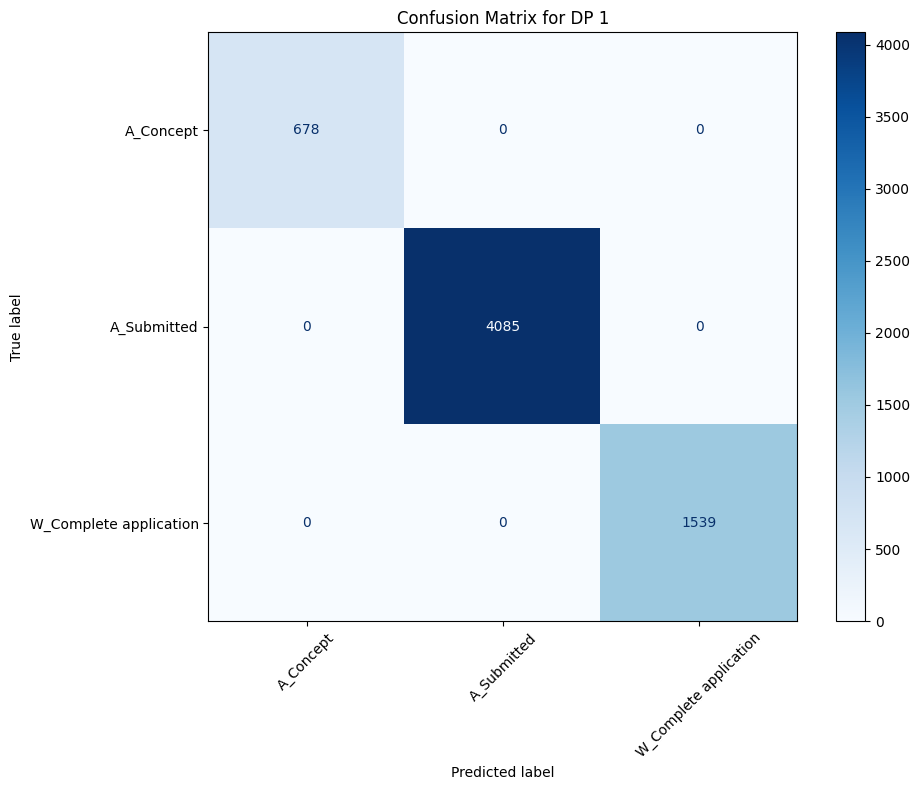

295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 3 (Holdout Set)
Weighted F1 (LSTM):     0.976
Weighted F1 (Baseline): 0.513
Relative Improvement:   90.26%


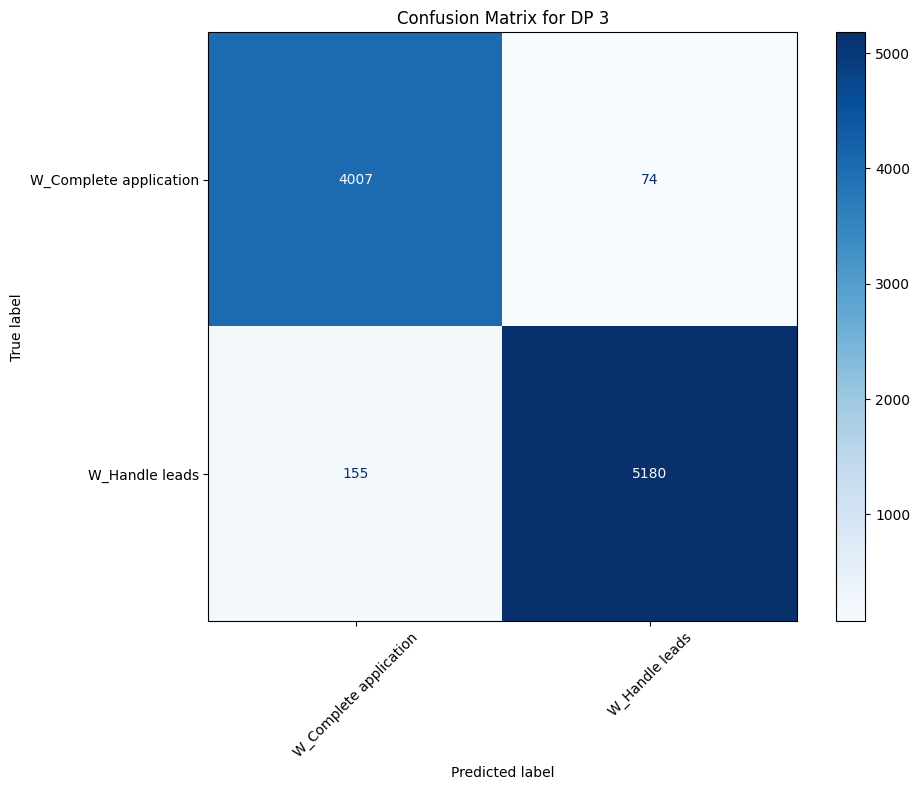

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 4 (Holdout Set)
Weighted F1 (LSTM):     0.999
Weighted F1 (Baseline): 0.804
Relative Improvement:   24.22%


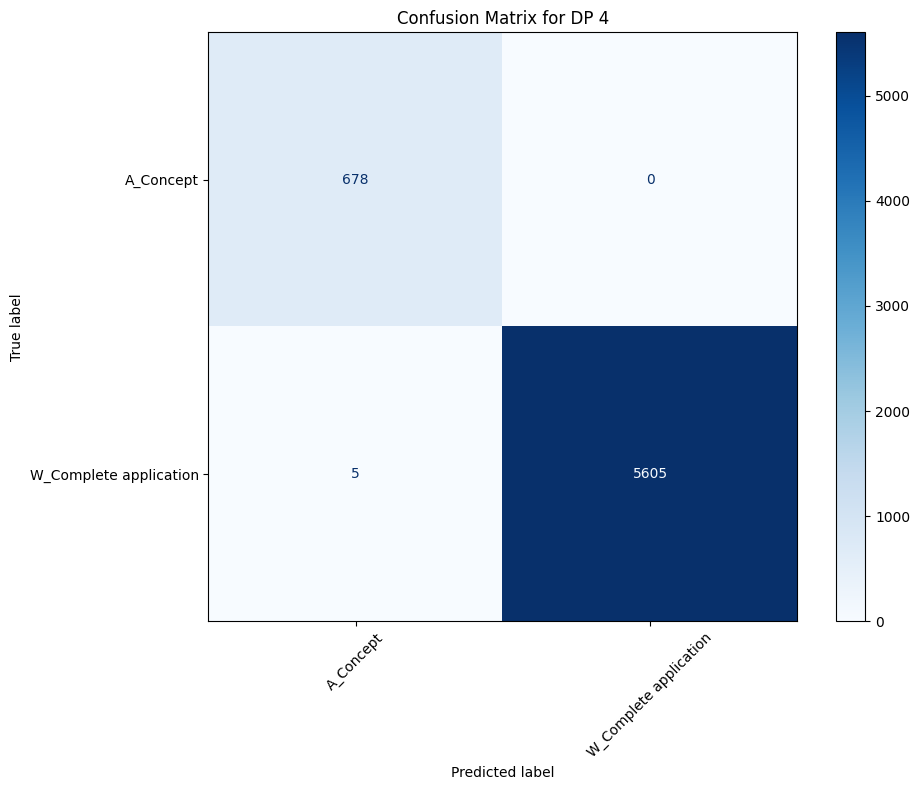

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 5 (Holdout Set)
Weighted F1 (LSTM):     0.999
Weighted F1 (Baseline): 0.804
Relative Improvement:   24.22%


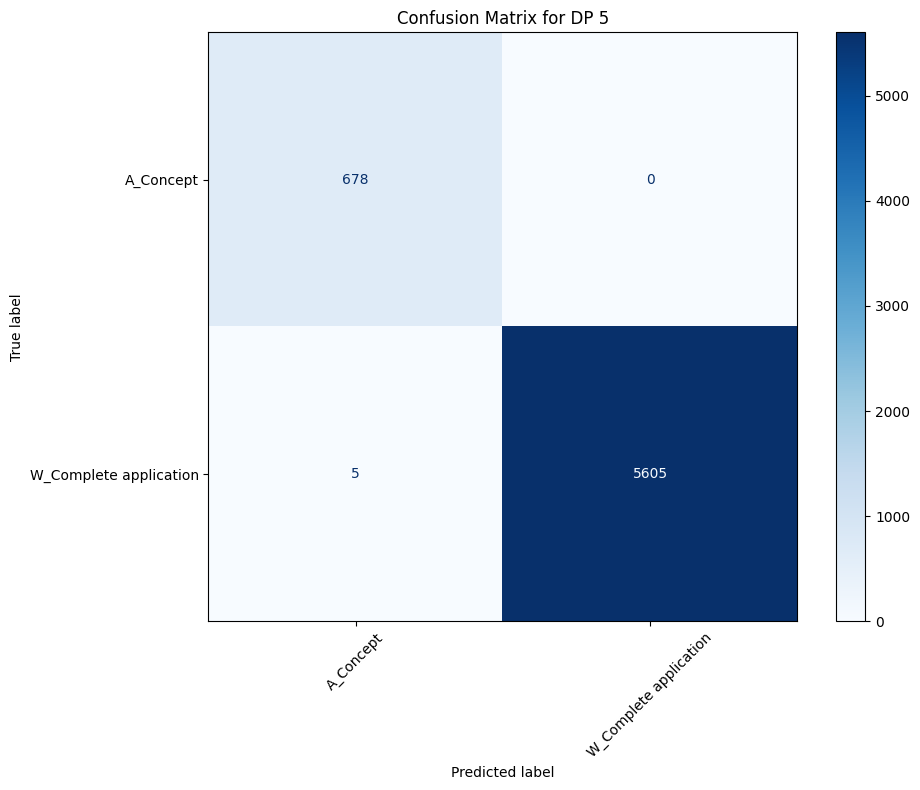

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 7 (Holdout Set)
Weighted F1 (LSTM):     0.679
Weighted F1 (Baseline): 0.405
Relative Improvement:   67.84%


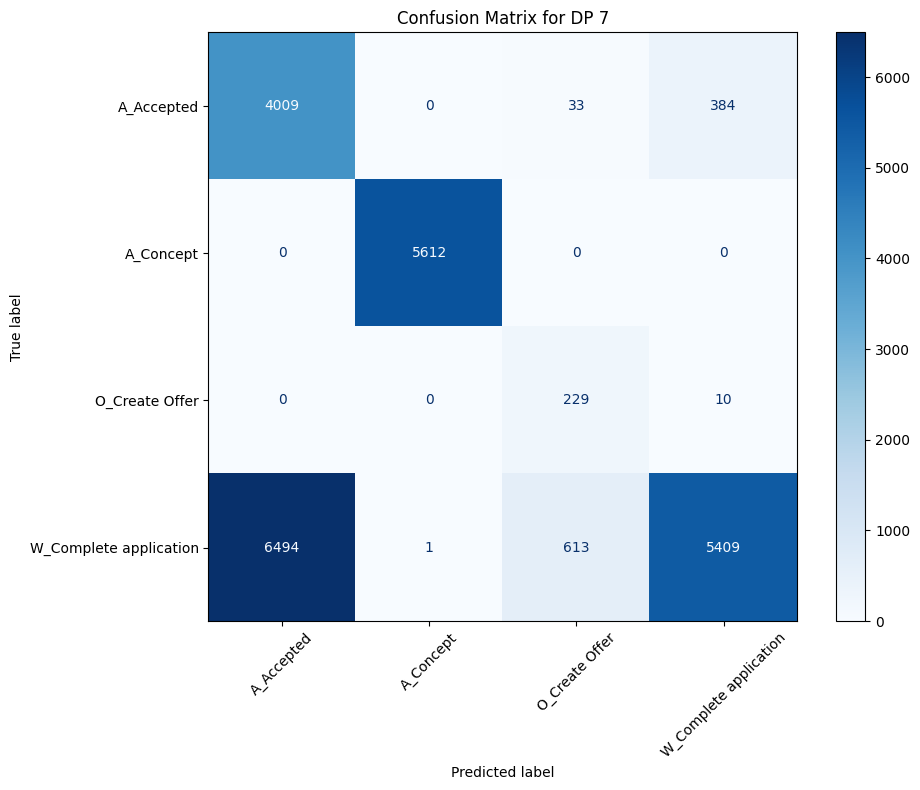

909/909 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 8 (Holdout Set)
Weighted F1 (LSTM):     0.735
Weighted F1 (Baseline): 0.460
Relative Improvement:   59.62%


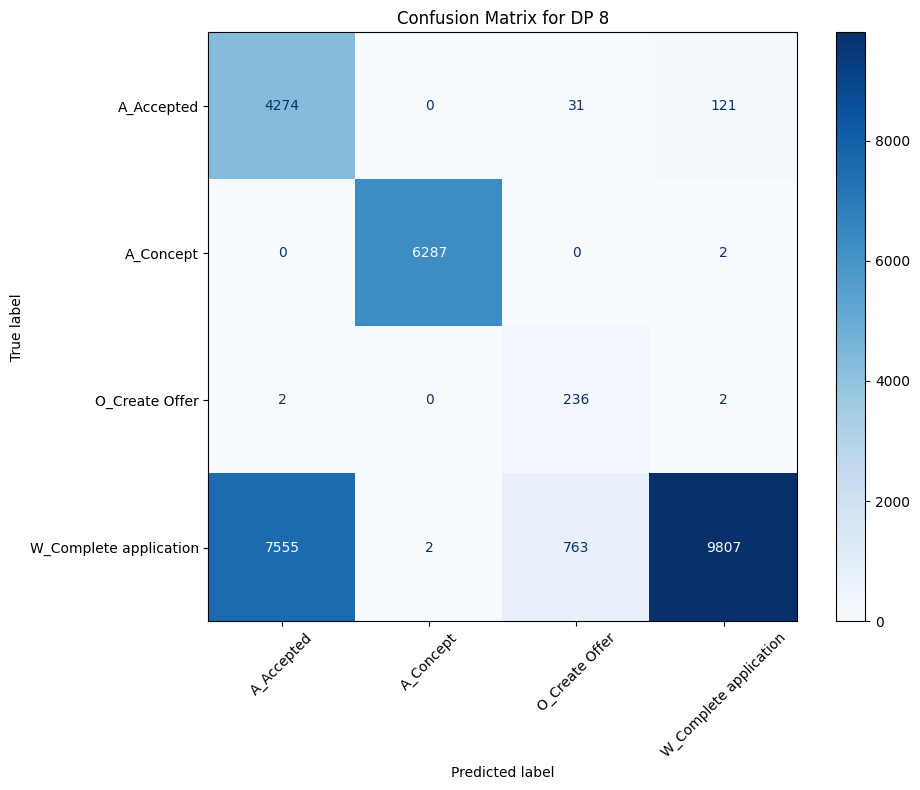

1121/1121 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 9 (Holdout Set)
Weighted F1 (LSTM):     0.777
Weighted F1 (Baseline): 0.496
Relative Improvement:   56.65%


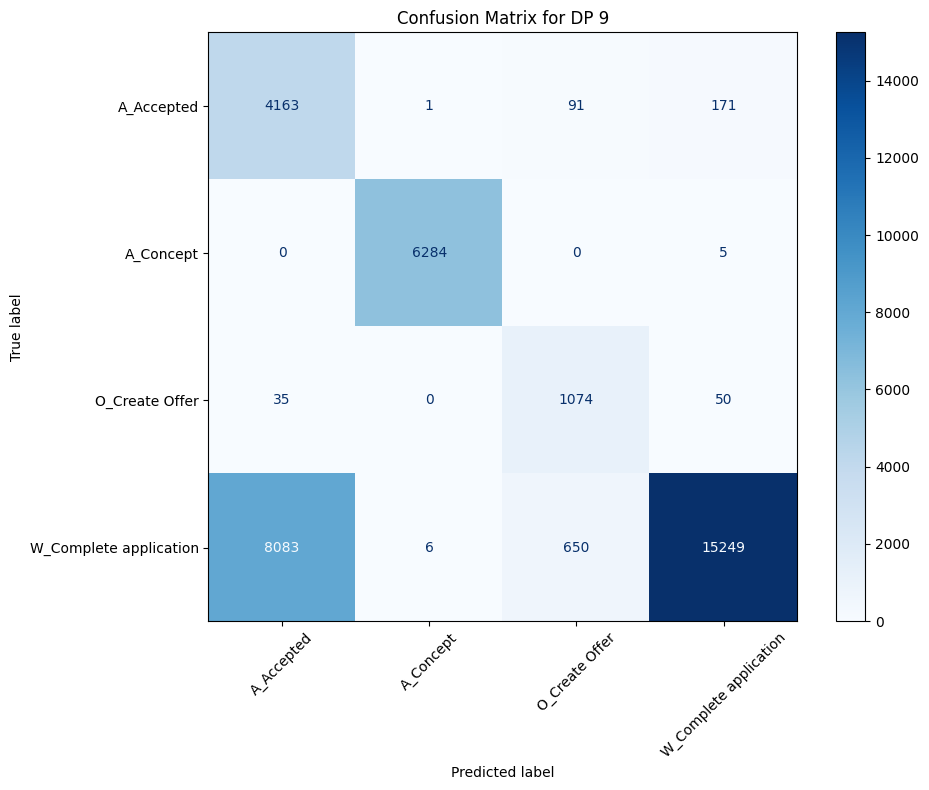

1121/1121 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 10 (Holdout Set)
Weighted F1 (LSTM):     0.771
Weighted F1 (Baseline): 0.496
Relative Improvement:   55.43%


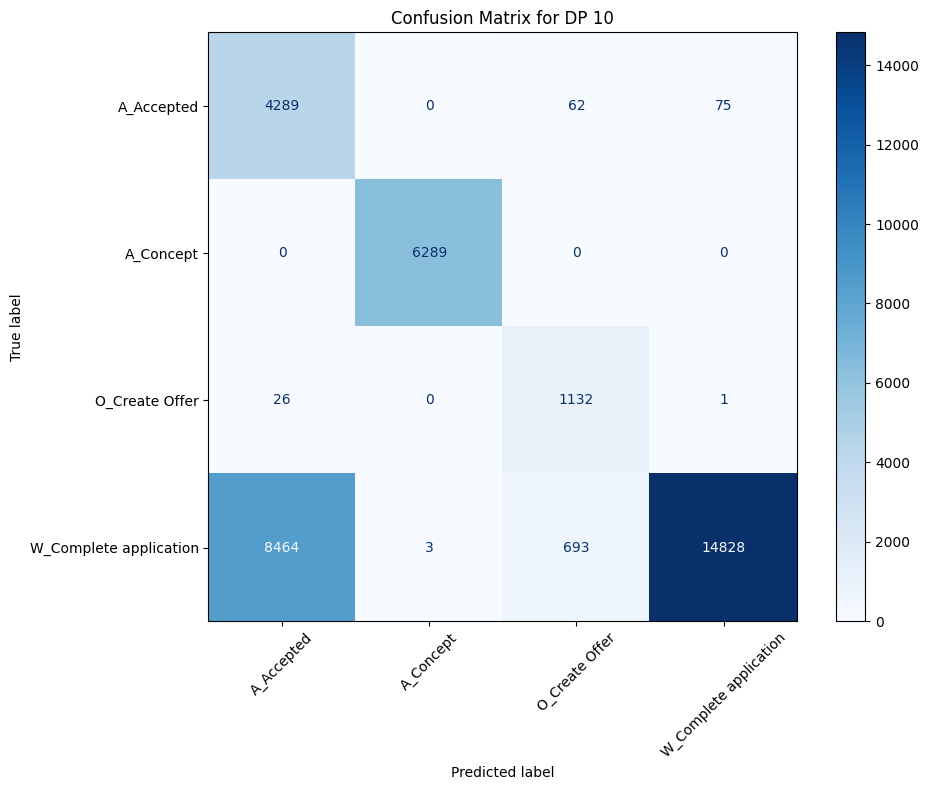

1121/1121 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 11 (Holdout Set)
Weighted F1 (LSTM):     0.783
Weighted F1 (Baseline): 0.662
Relative Improvement:   18.42%


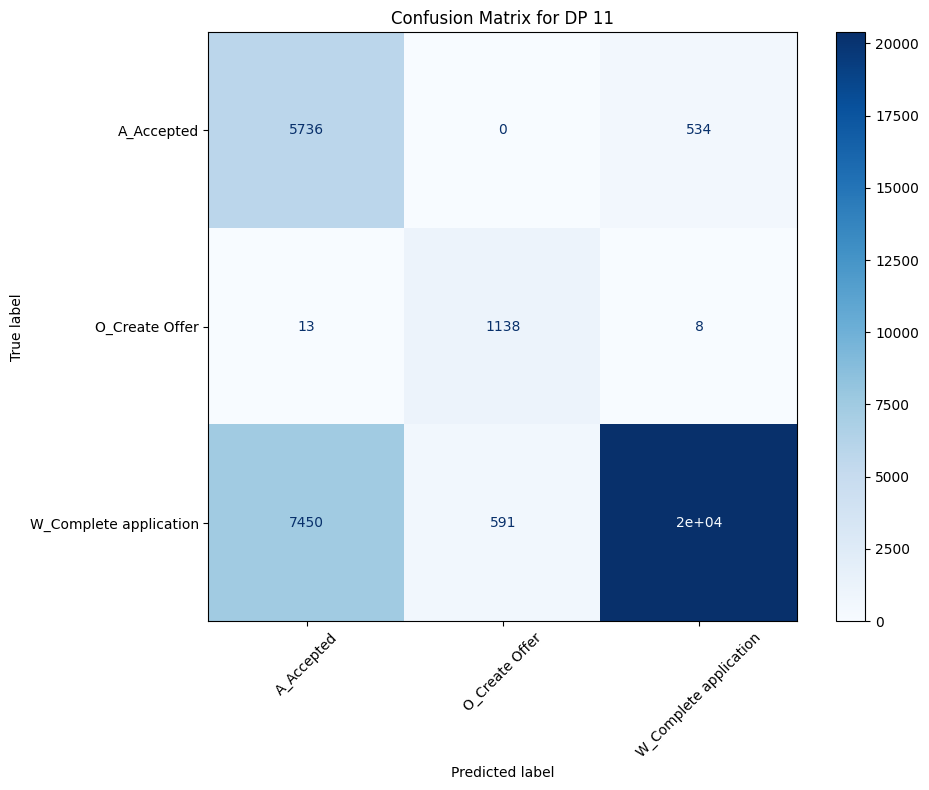

1121/1121 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Comparison for DP 12 (Holdout Set)
Weighted F1 (LSTM):     0.775
Weighted F1 (Baseline): 0.662
Relative Improvement:   17.11%


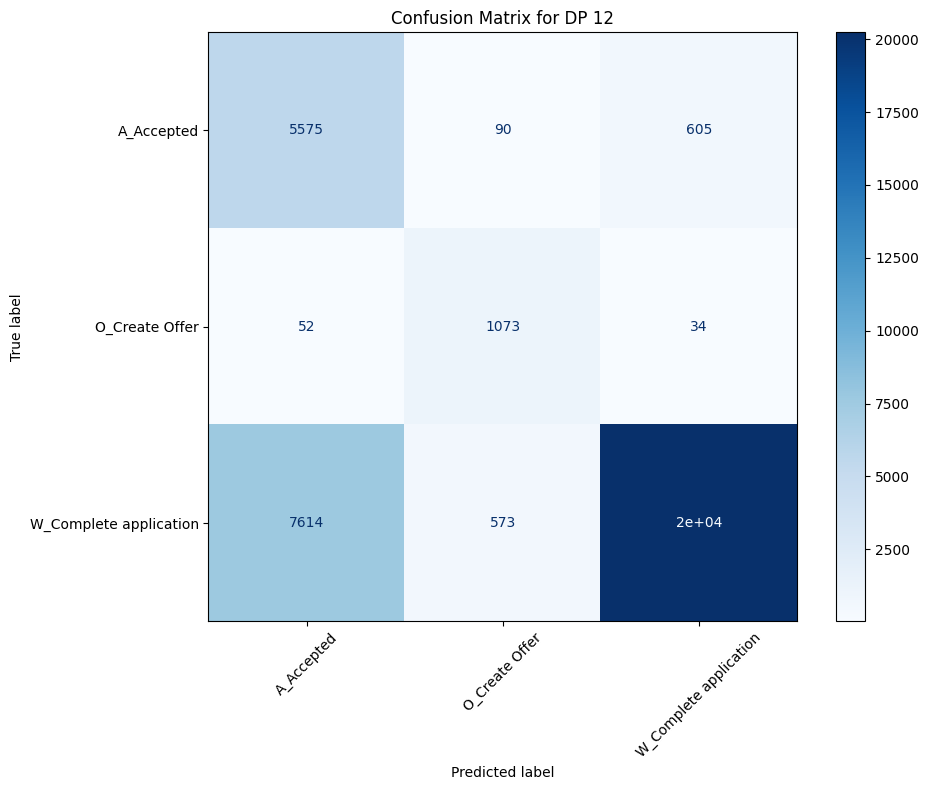

1119/1119 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 13 (Holdout Set)
Weighted F1 (LSTM):     0.984
Weighted F1 (Baseline): 0.683
Relative Improvement:   44.10%


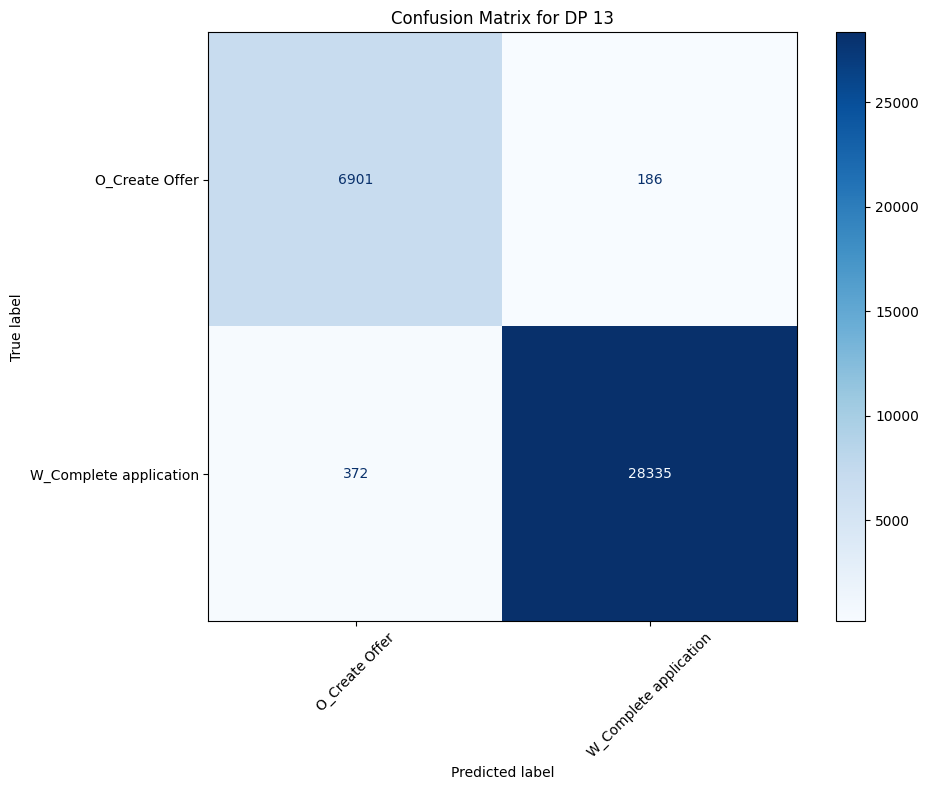

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 14 (Holdout Set)
Weighted F1 (LSTM):     0.932
Weighted F1 (Baseline): 0.928
Relative Improvement:   0.39%


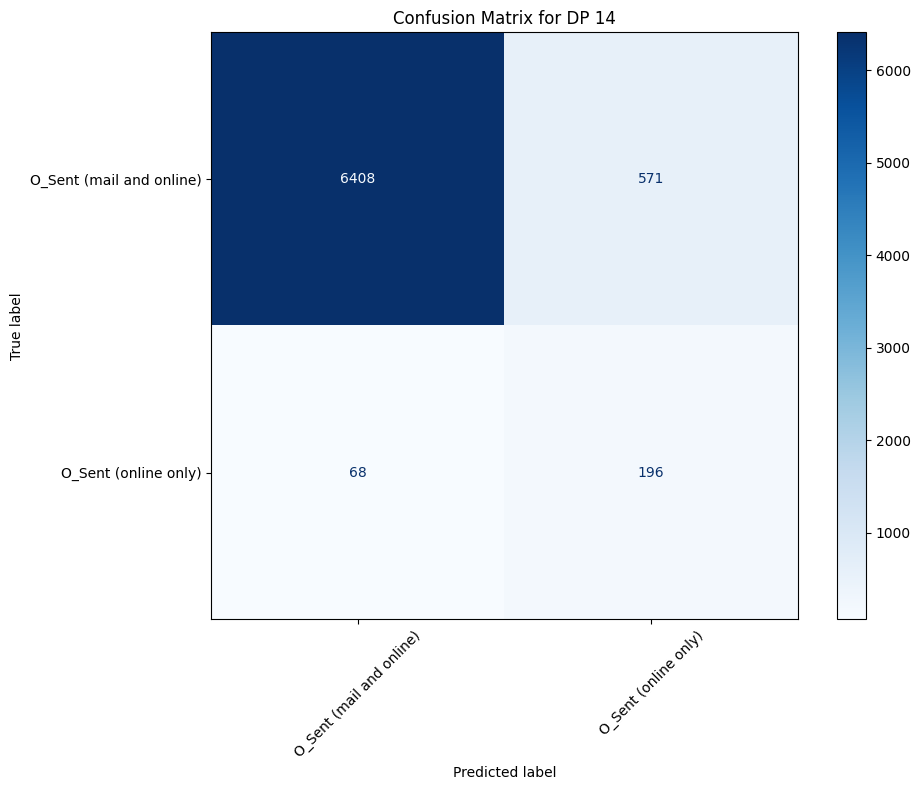

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 15 (Holdout Set)
Weighted F1 (LSTM):     0.920
Weighted F1 (Baseline): 0.928
Relative Improvement:   -0.88%


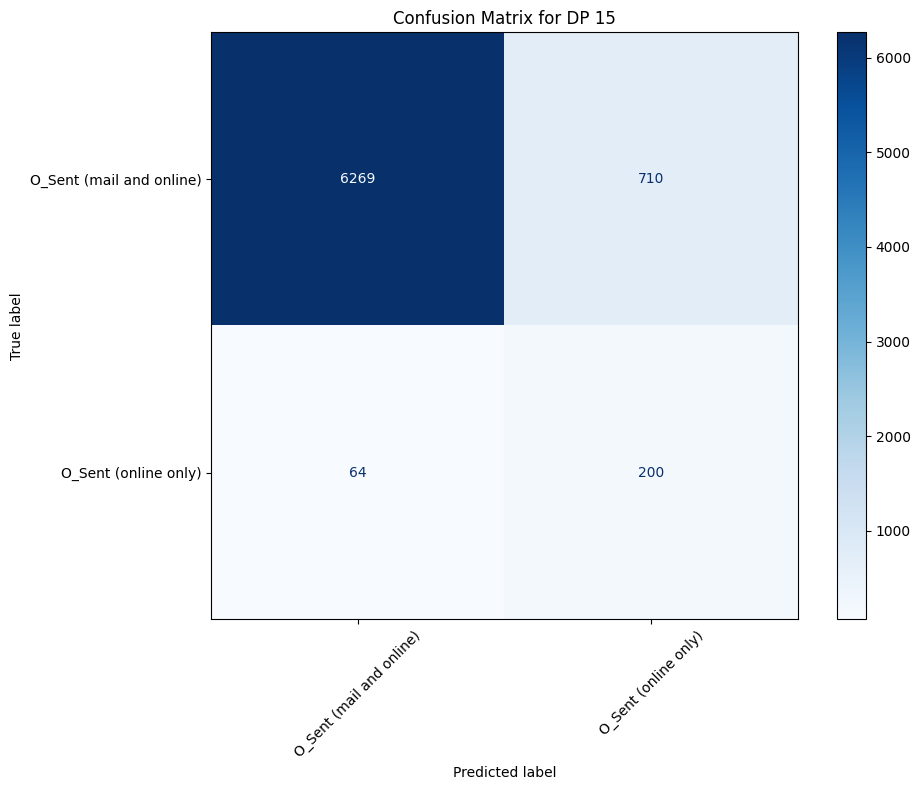

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 16 (Holdout Set)
Weighted F1 (LSTM):     0.979
Weighted F1 (Baseline): 0.793
Relative Improvement:   23.53%


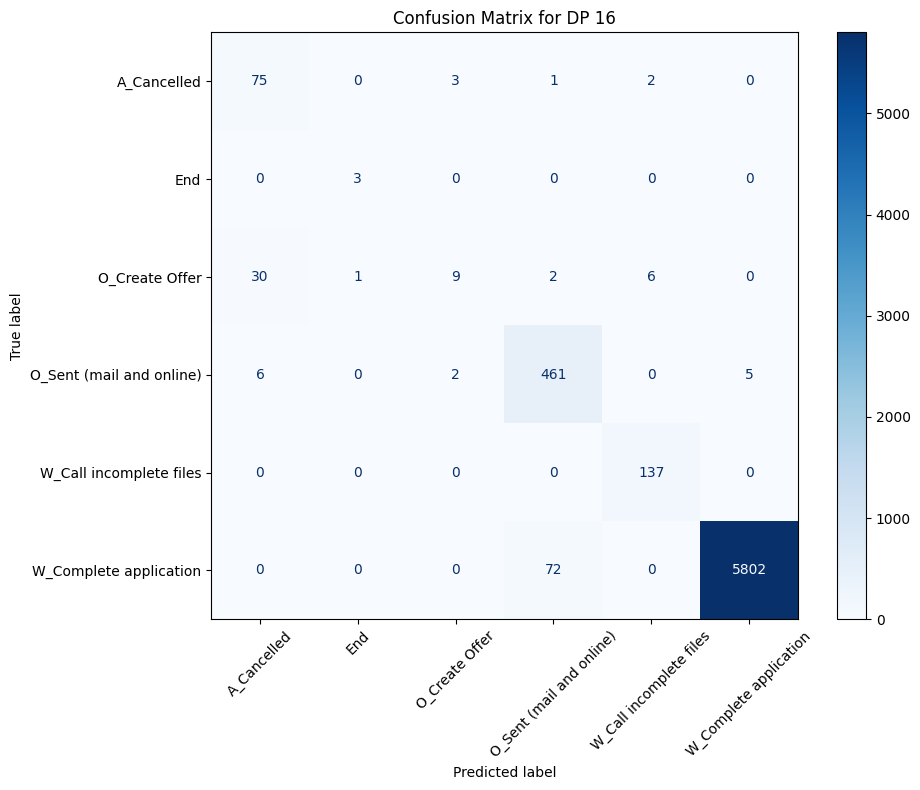

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 17 (Holdout Set)
Weighted F1 (LSTM):     0.979
Weighted F1 (Baseline): 0.793
Relative Improvement:   23.42%


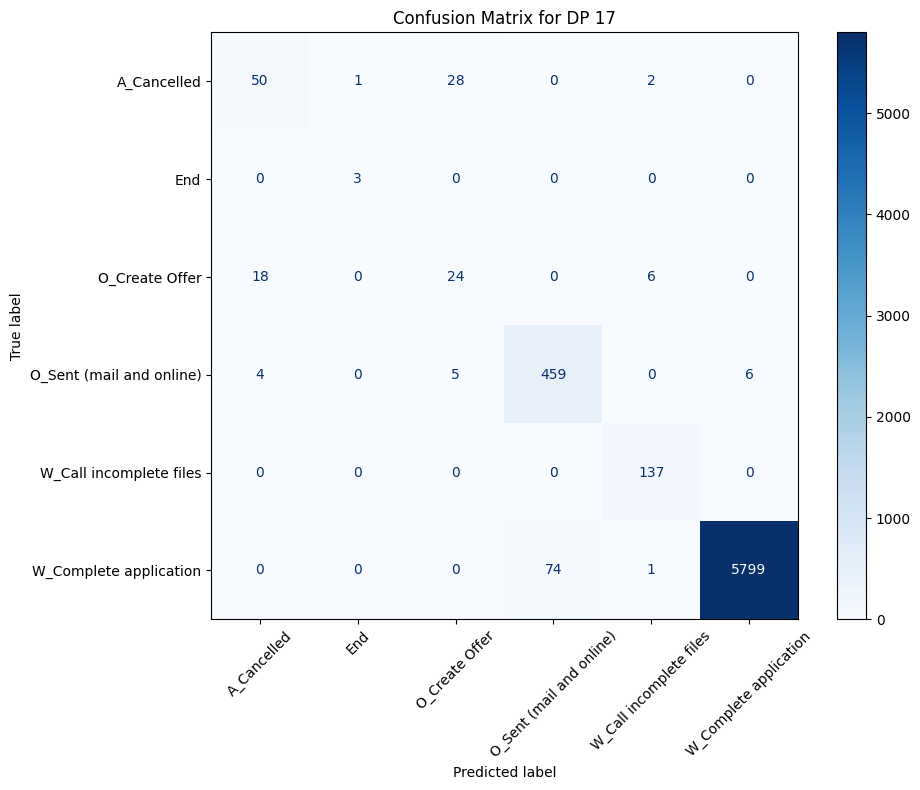

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 19 (Holdout Set)
Weighted F1 (LSTM):     0.734
Weighted F1 (Baseline): 0.414
Relative Improvement:   77.17%


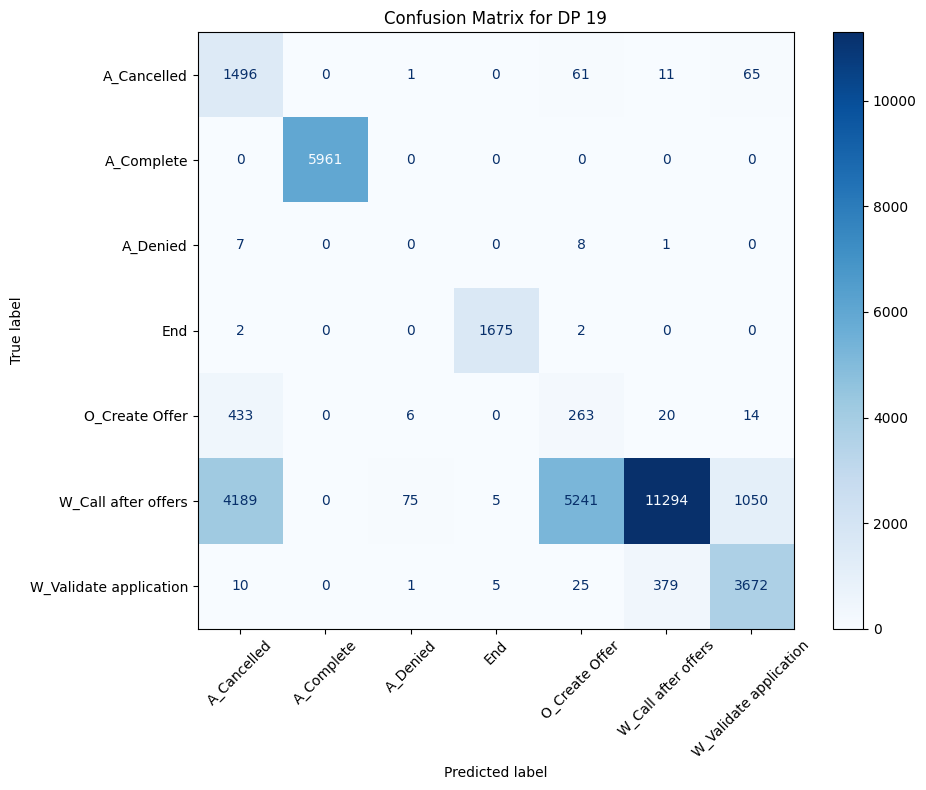

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 20 (Holdout Set)
Weighted F1 (LSTM):     0.704
Weighted F1 (Baseline): 0.414
Relative Improvement:   69.97%


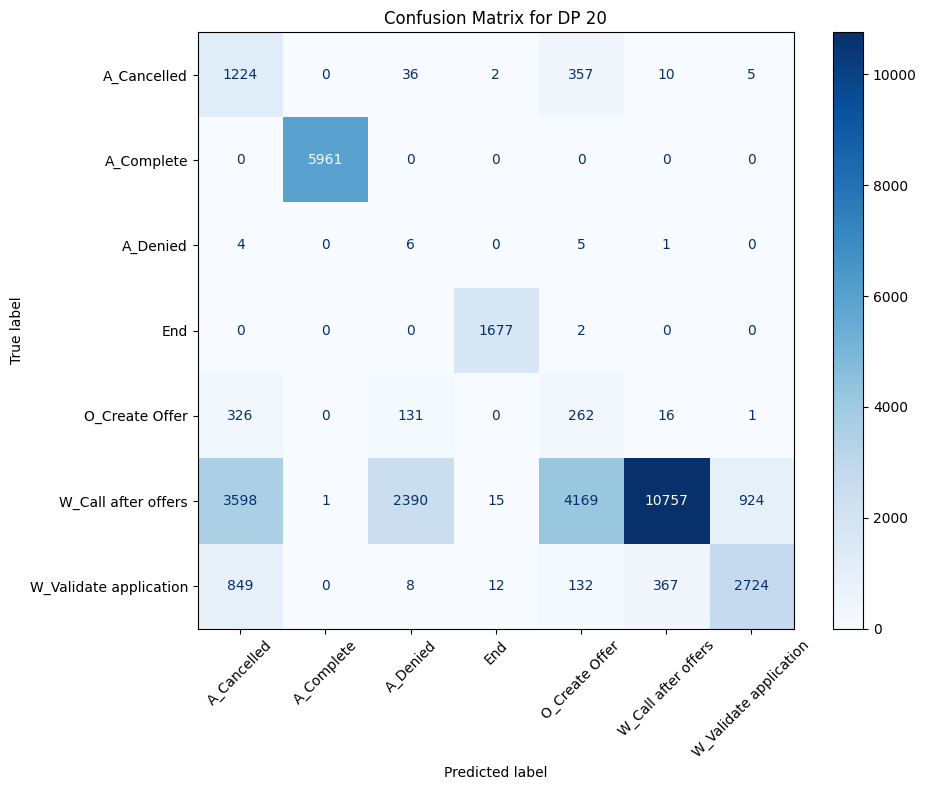

1124/1124 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 21 (Holdout Set)
Weighted F1 (LSTM):     0.686
Weighted F1 (Baseline): 0.611
Relative Improvement:   12.32%


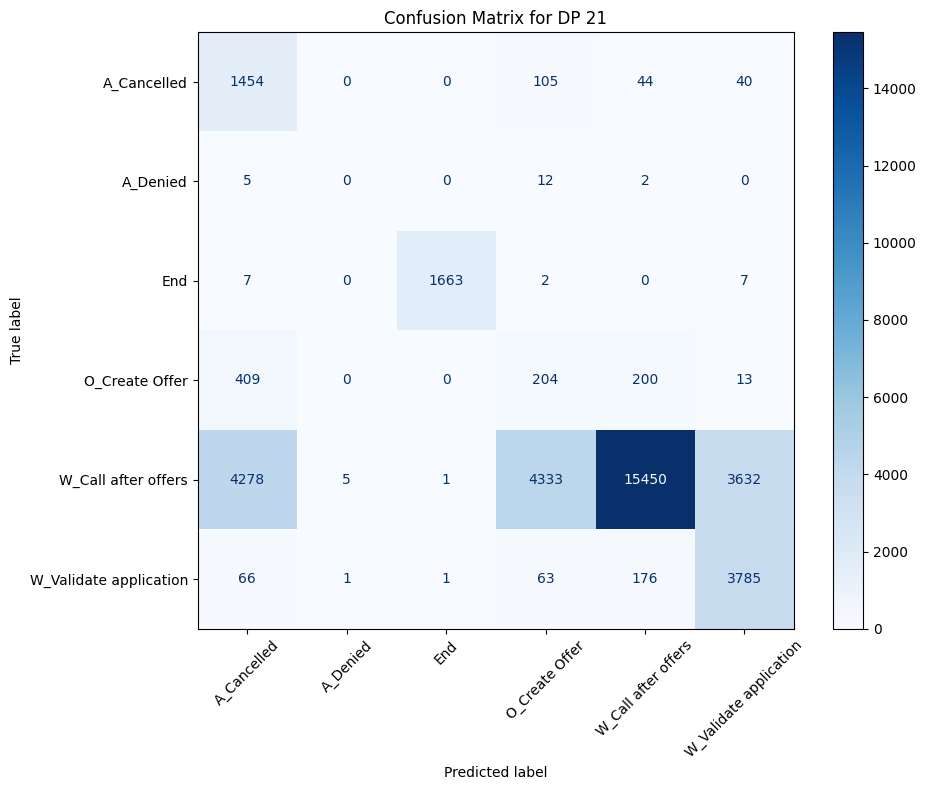

1124/1124 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 22 (Holdout Set)
Weighted F1 (LSTM):     0.700
Weighted F1 (Baseline): 0.611
Relative Improvement:   14.72%


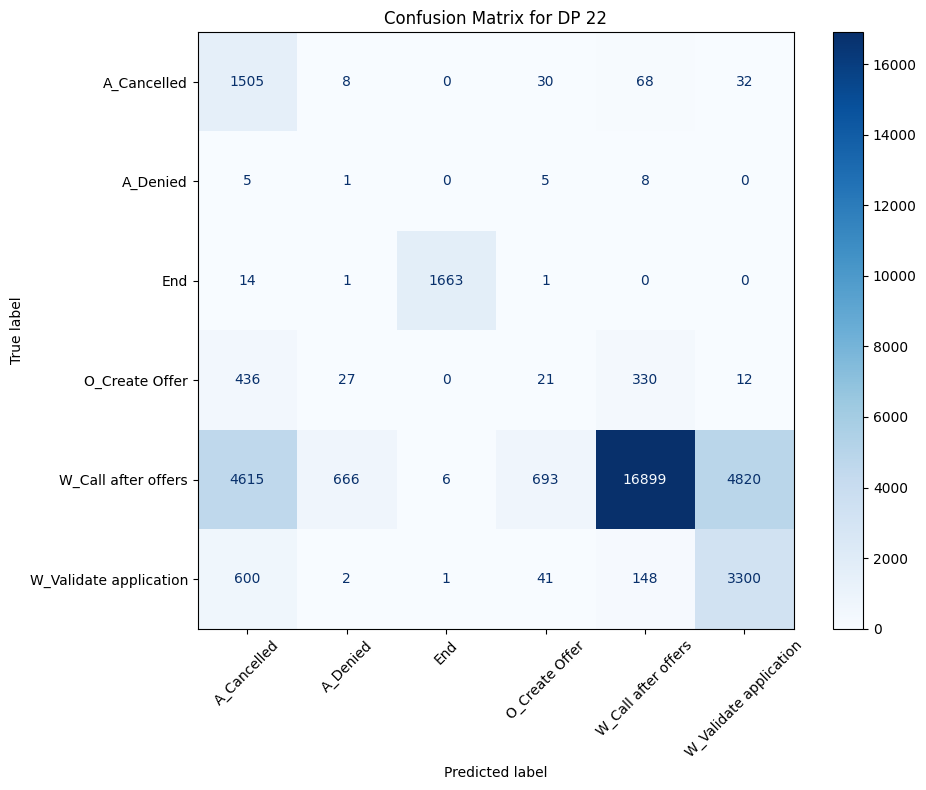

443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 23 (Holdout Set)
Weighted F1 (LSTM):     0.912
Weighted F1 (Baseline): 0.284
Relative Improvement:   221.43%


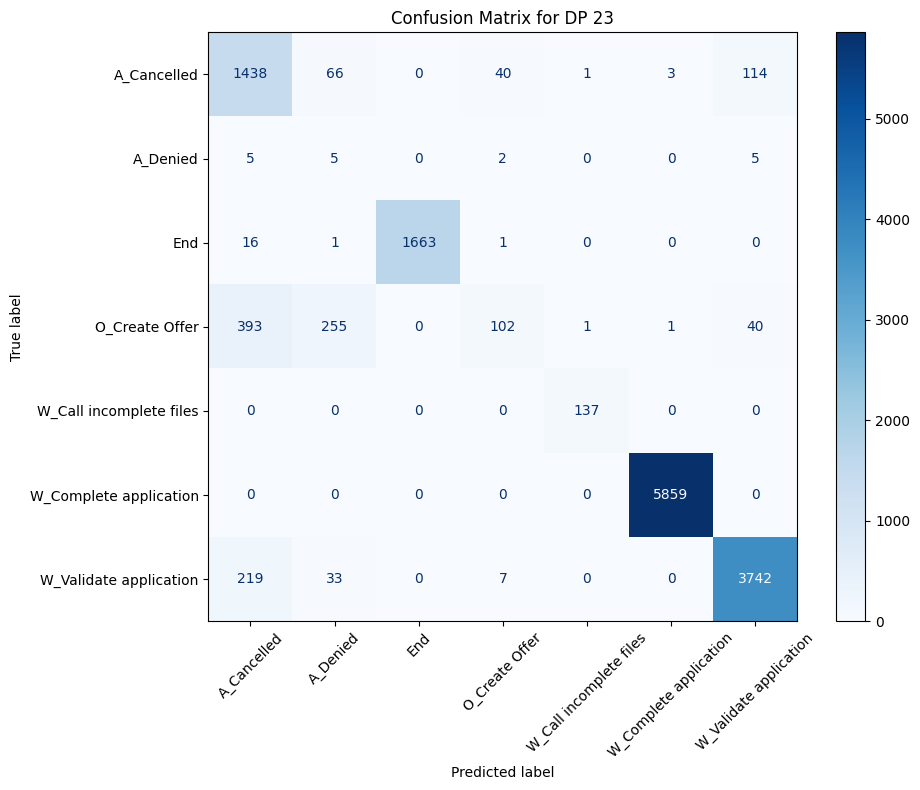

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 25 (Holdout Set)
Weighted F1 (LSTM):     0.795
Weighted F1 (Baseline): 0.448
Relative Improvement:   77.59%


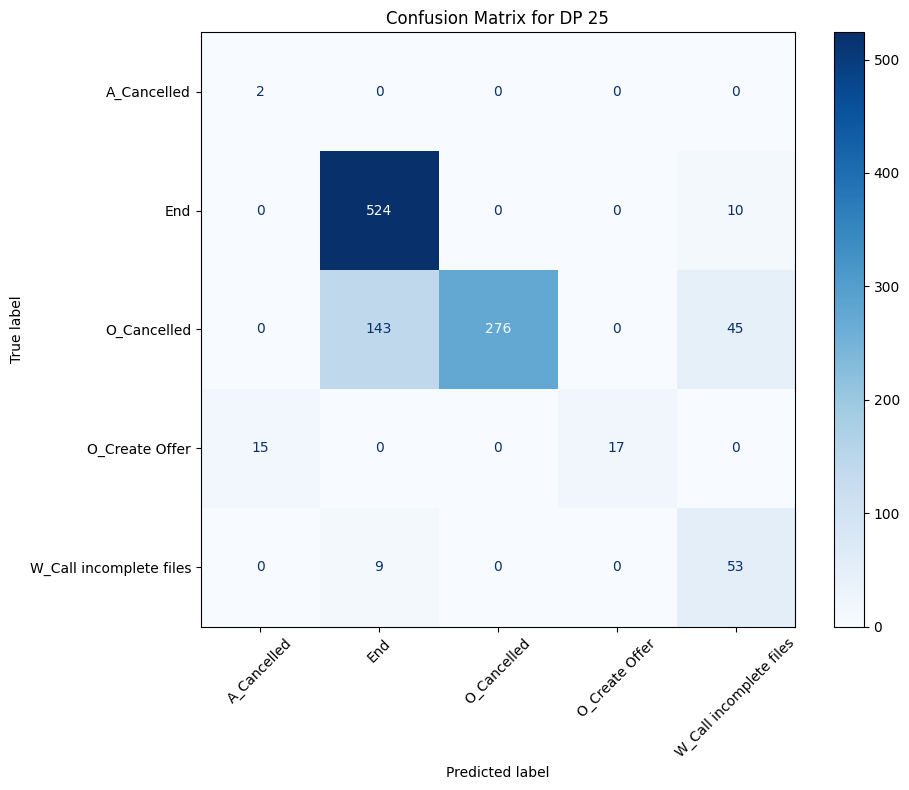

461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 26 (Holdout Set)
Weighted F1 (LSTM):     0.927
Weighted F1 (Baseline): 0.273
Relative Improvement:   239.70%


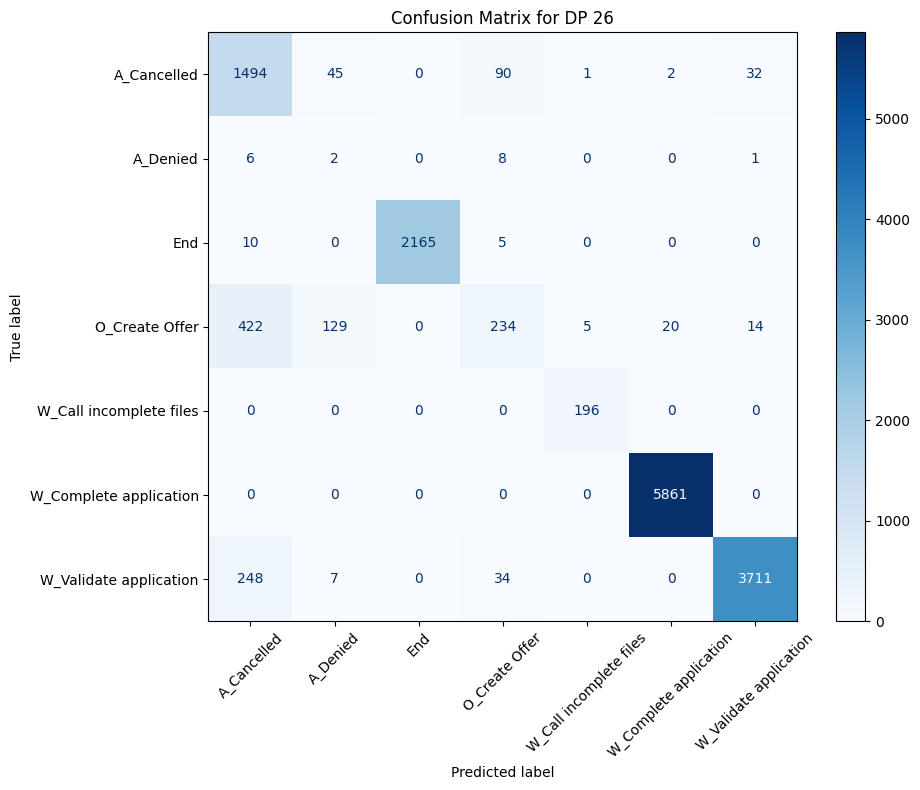

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 27 (Holdout Set)
Weighted F1 (LSTM):     0.785
Weighted F1 (Baseline): 0.329
Relative Improvement:   138.63%


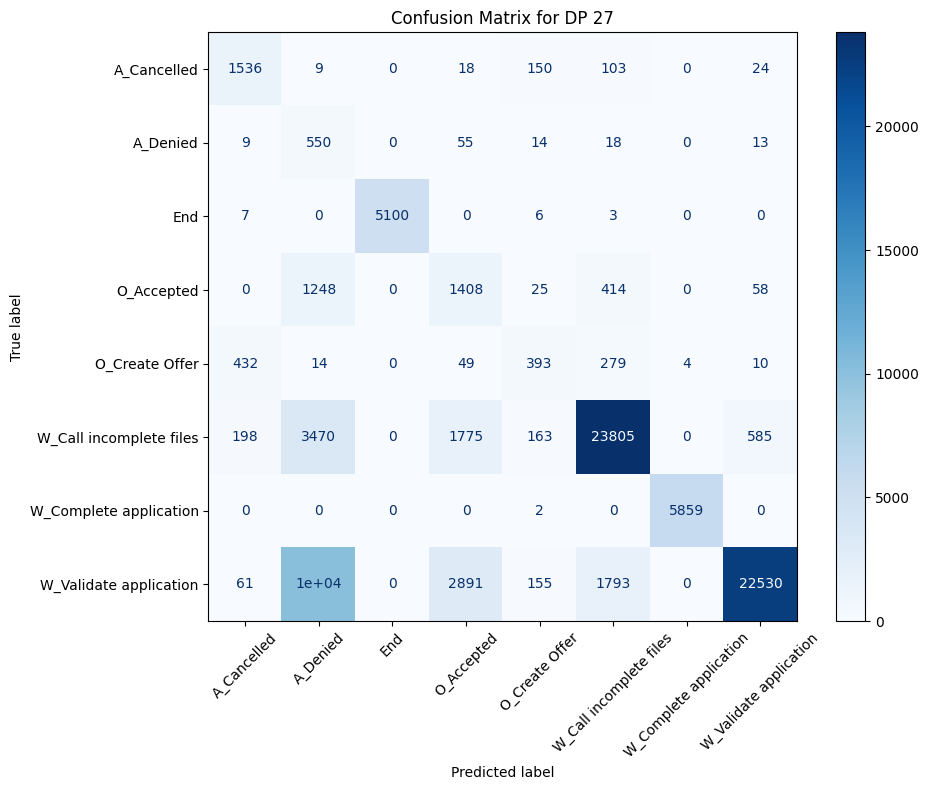

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 28 (Holdout Set)
Weighted F1 (LSTM):     0.784
Weighted F1 (Baseline): 0.329
Relative Improvement:   138.32%


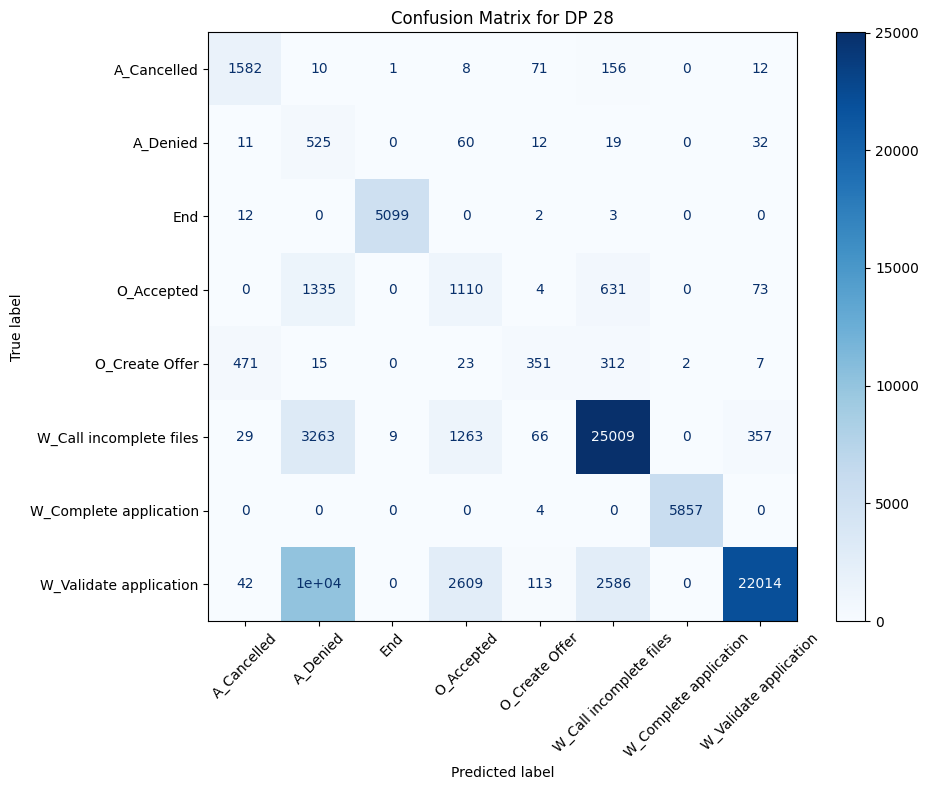

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 29 (Holdout Set)
Weighted F1 (LSTM):     0.775
Weighted F1 (Baseline): 0.329
Relative Improvement:   135.69%


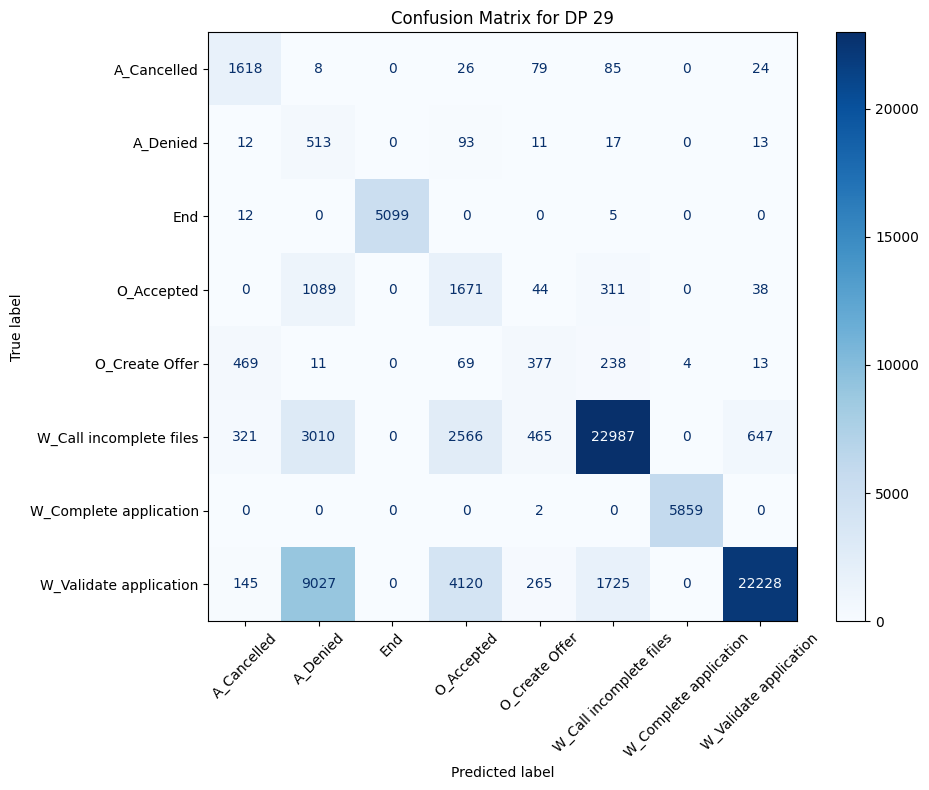

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Comparison for DP 30 (Holdout Set)
Weighted F1 (LSTM):     0.767
Weighted F1 (Baseline): 0.329
Relative Improvement:   133.21%


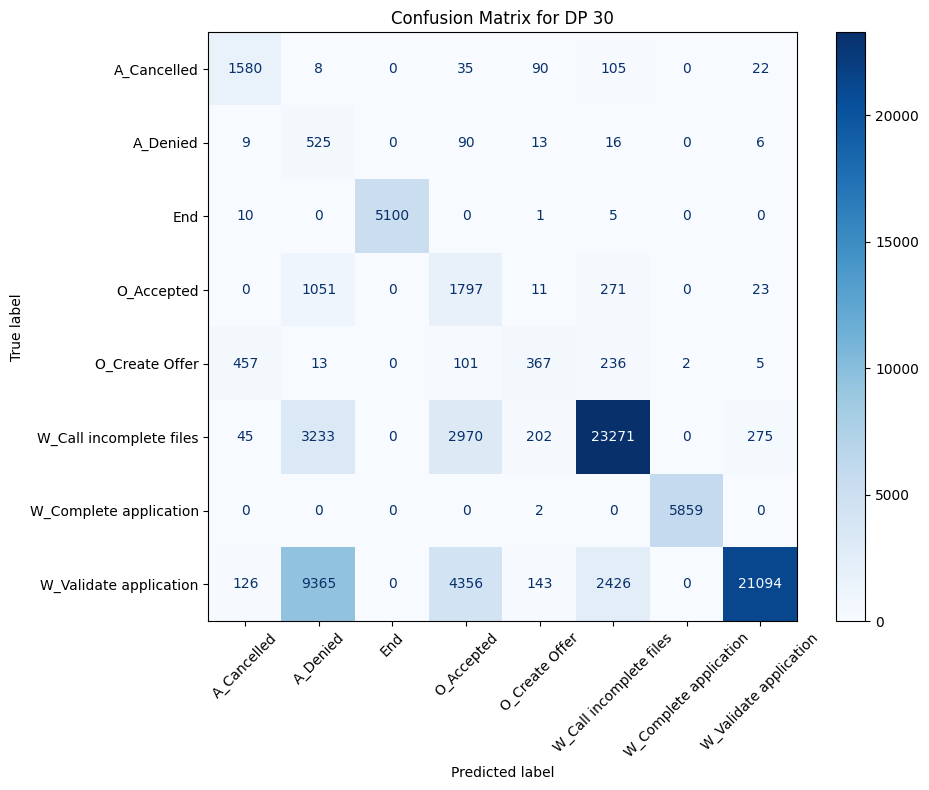

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 31 (Holdout Set)
Weighted F1 (LSTM):     0.584
Weighted F1 (Baseline): 0.373
Relative Improvement:   56.61%


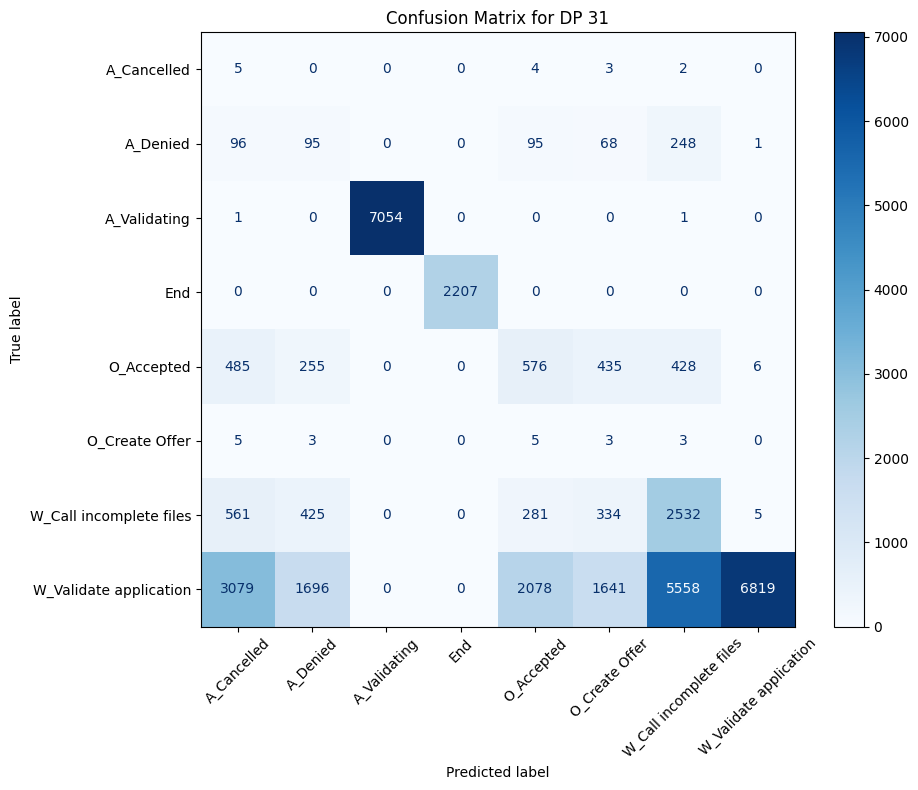

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 32 (Holdout Set)
Weighted F1 (LSTM):     0.775
Weighted F1 (Baseline): 0.329
Relative Improvement:   135.62%


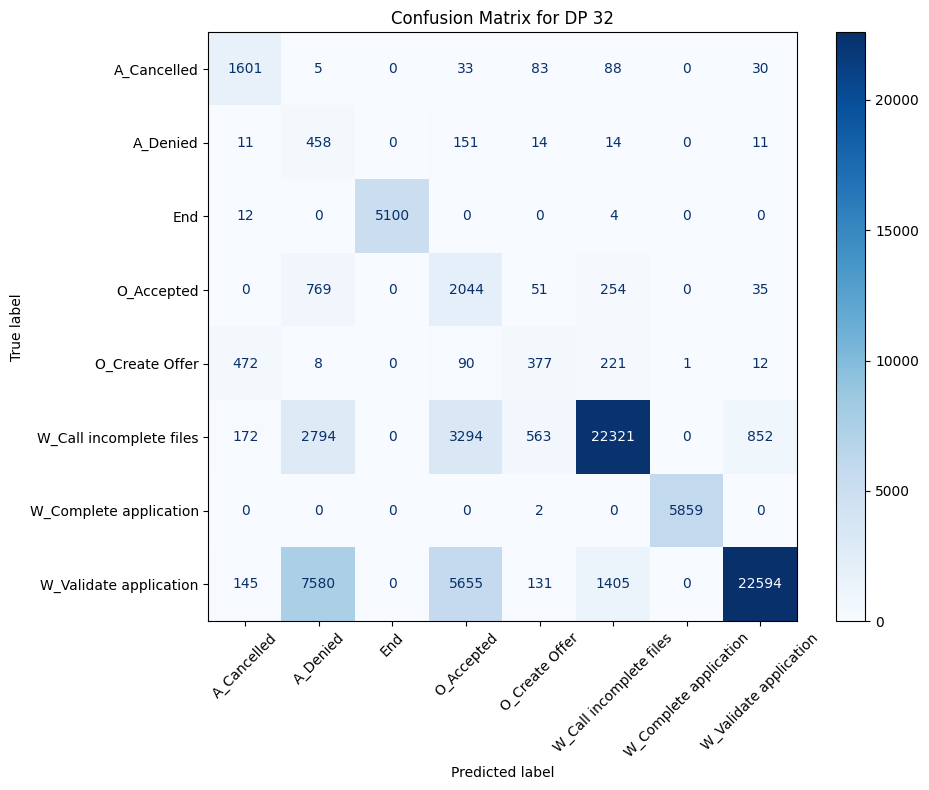

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 33 (Holdout Set)
Weighted F1 (LSTM):     0.935
Weighted F1 (Baseline): 0.489
Relative Improvement:   91.25%


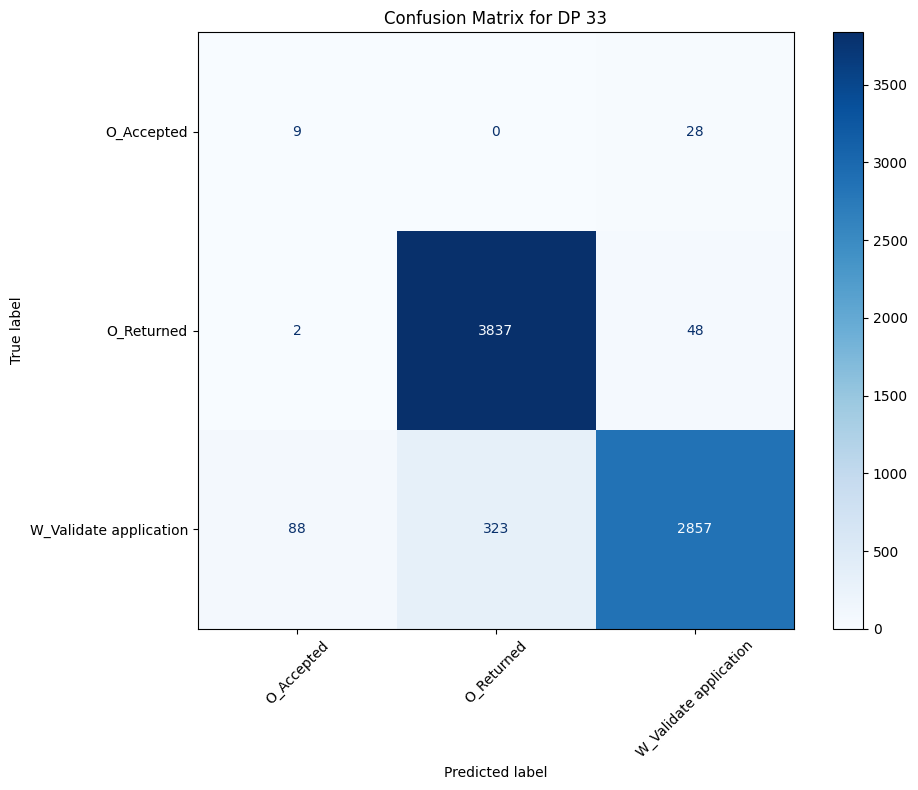

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 34 (Holdout Set)
Weighted F1 (LSTM):     0.775
Weighted F1 (Baseline): 0.329
Relative Improvement:   135.60%


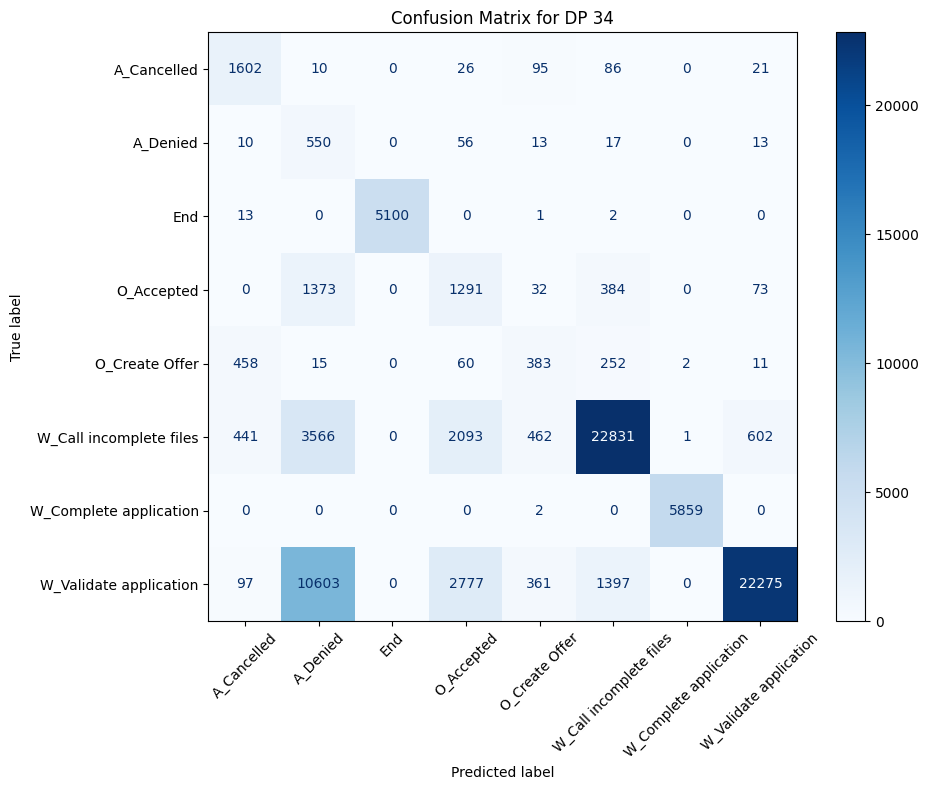

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 35 (Holdout Set)
Weighted F1 (LSTM):     0.767
Weighted F1 (Baseline): 0.329
Relative Improvement:   133.31%


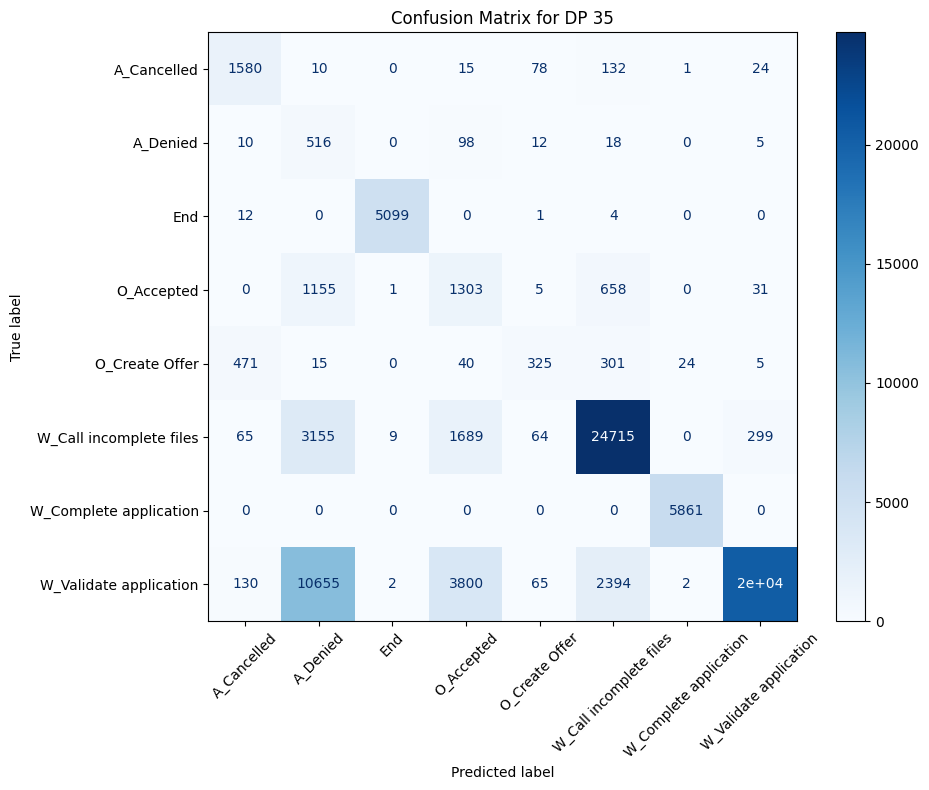

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 36 (Holdout Set)
Weighted F1 (LSTM):     0.763
Weighted F1 (Baseline): 0.329
Relative Improvement:   132.12%


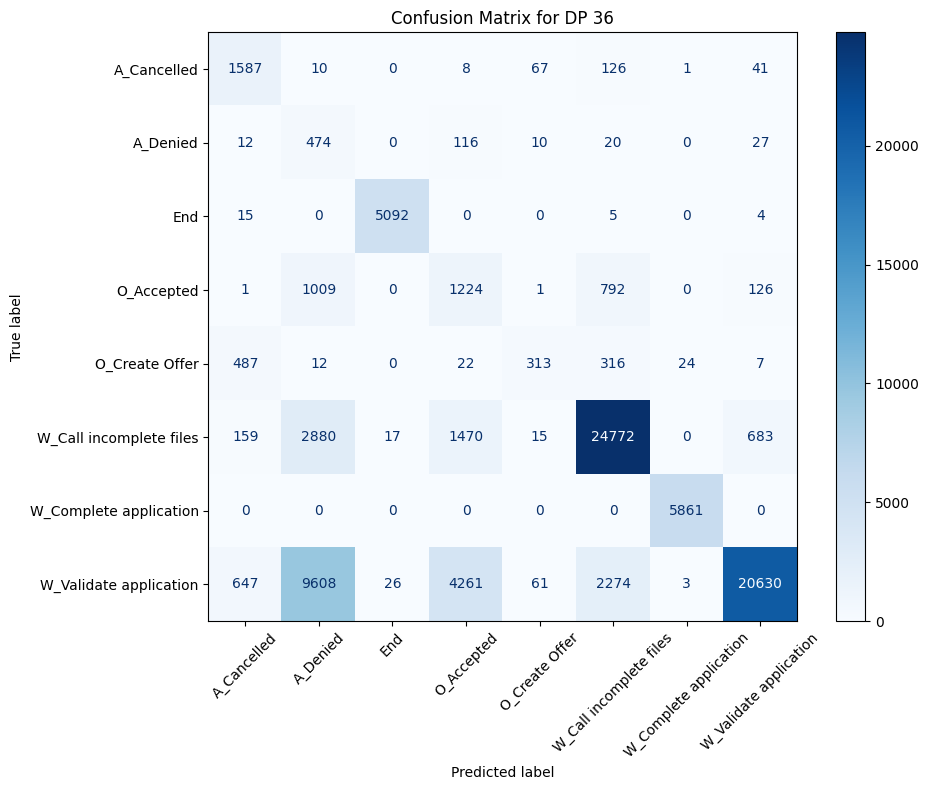

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 37 (Holdout Set)
Weighted F1 (LSTM):     0.771
Weighted F1 (Baseline): 0.329
Relative Improvement:   134.52%


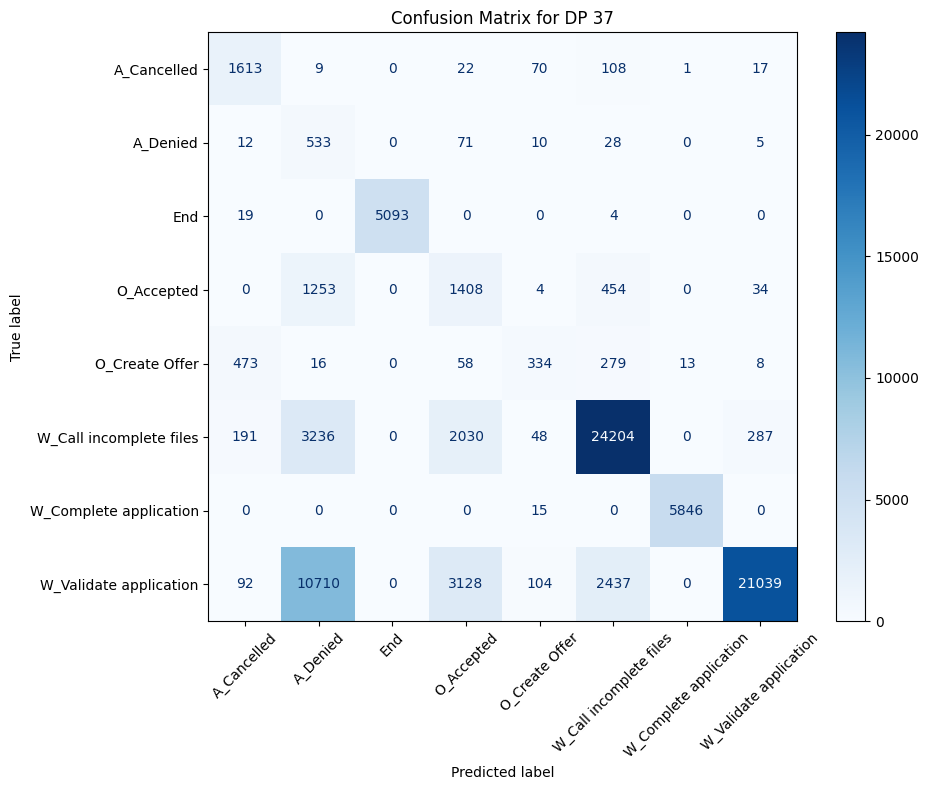

935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 39 (Holdout Set)
Weighted F1 (LSTM):     0.567
Weighted F1 (Baseline): 0.510
Relative Improvement:   11.26%


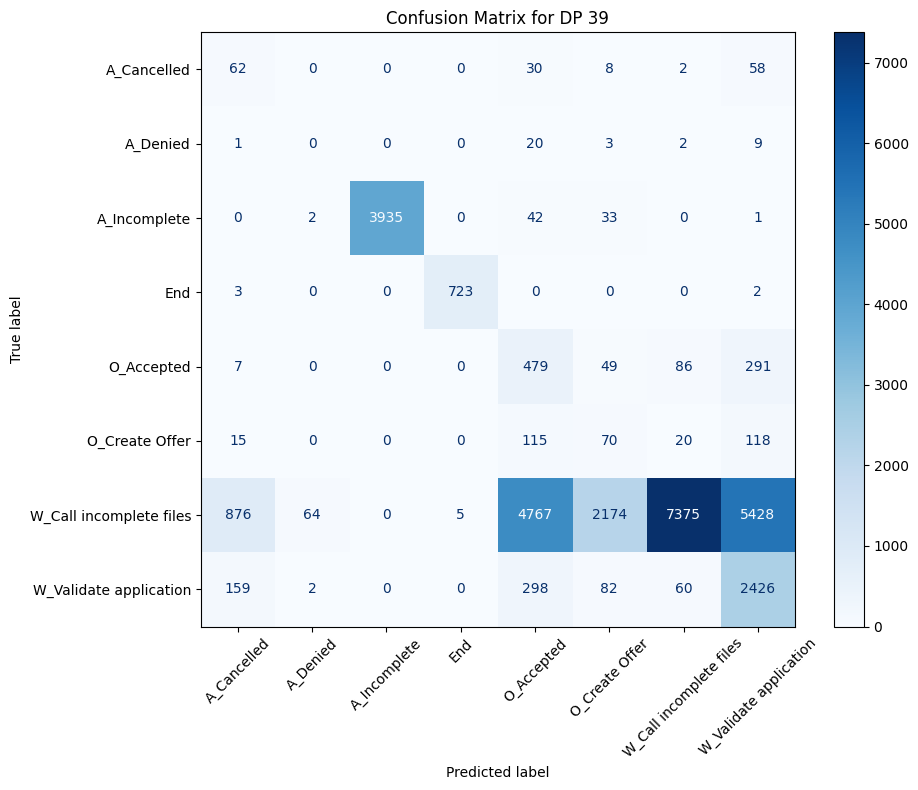

934/934 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 40 (Holdout Set)
Weighted F1 (LSTM):     0.635
Weighted F1 (Baseline): 0.694
Relative Improvement:   -8.45%


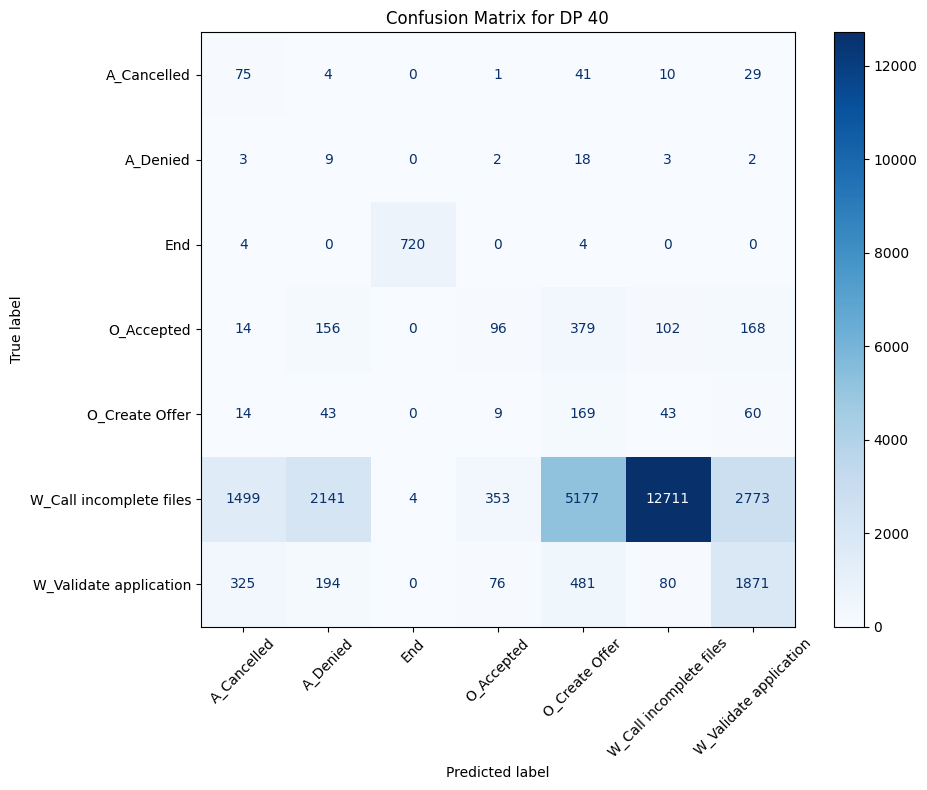

934/934 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Comparison for DP 41 (Holdout Set)
Weighted F1 (LSTM):     0.621
Weighted F1 (Baseline): 0.694
Relative Improvement:   -10.55%


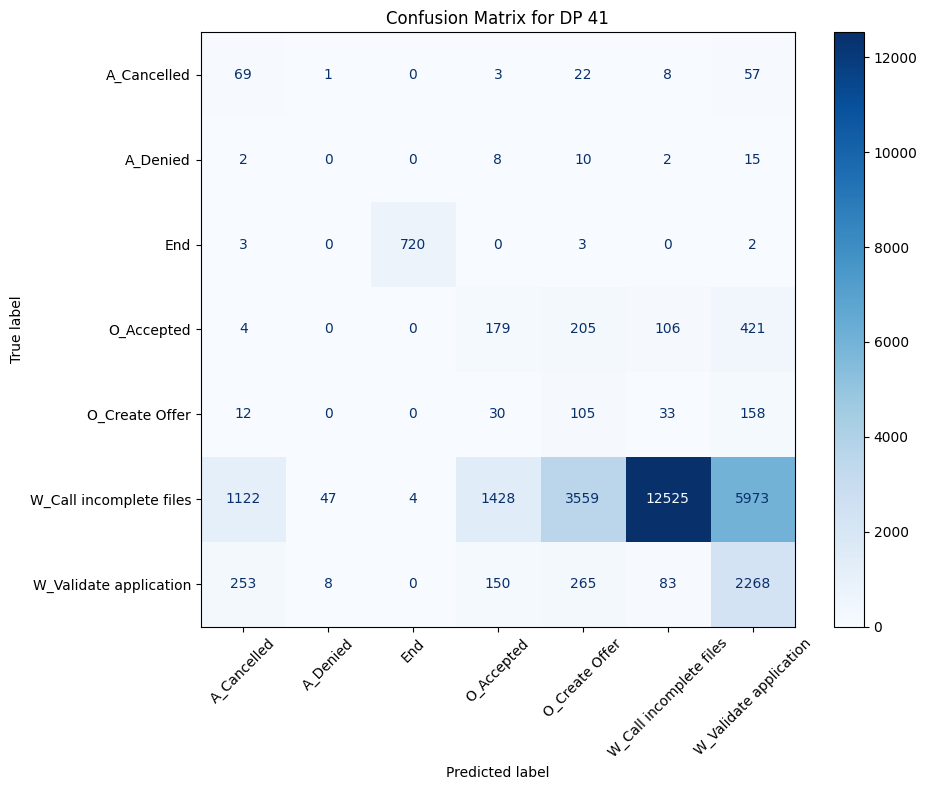

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 42 (Holdout Set)
Weighted F1 (LSTM):     0.771
Weighted F1 (Baseline): 0.329
Relative Improvement:   134.40%


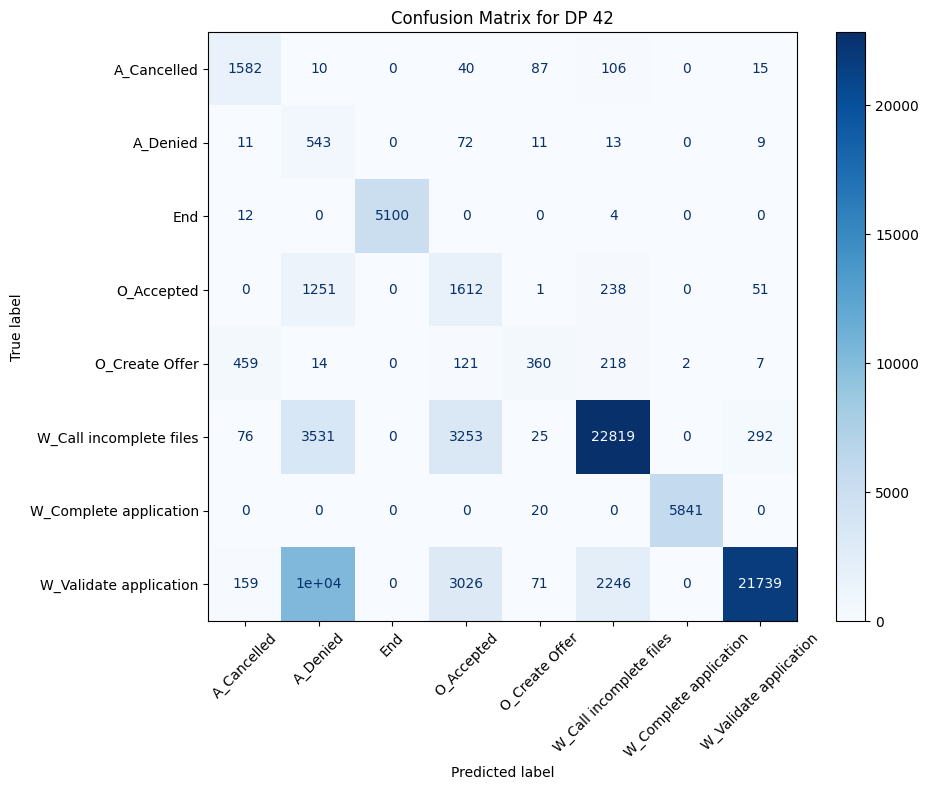

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 43 (Holdout Set)
Weighted F1 (LSTM):     0.774
Weighted F1 (Baseline): 0.329
Relative Improvement:   135.41%


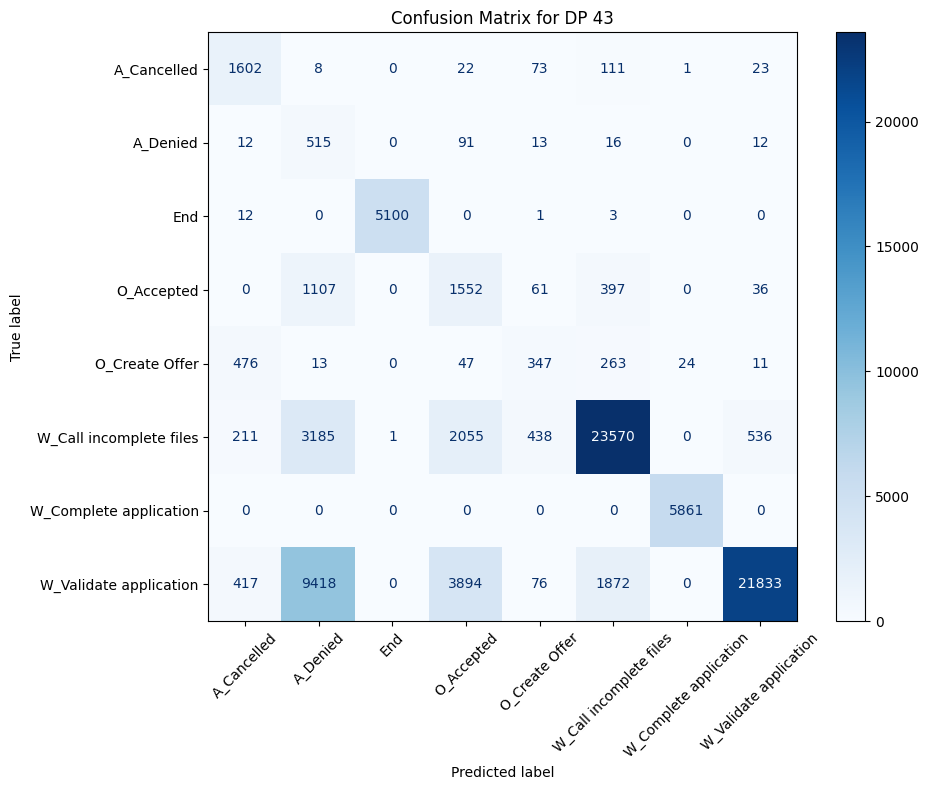

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 44 (Holdout Set)
Weighted F1 (LSTM):     0.817
Weighted F1 (Baseline): 0.440
Relative Improvement:   85.80%


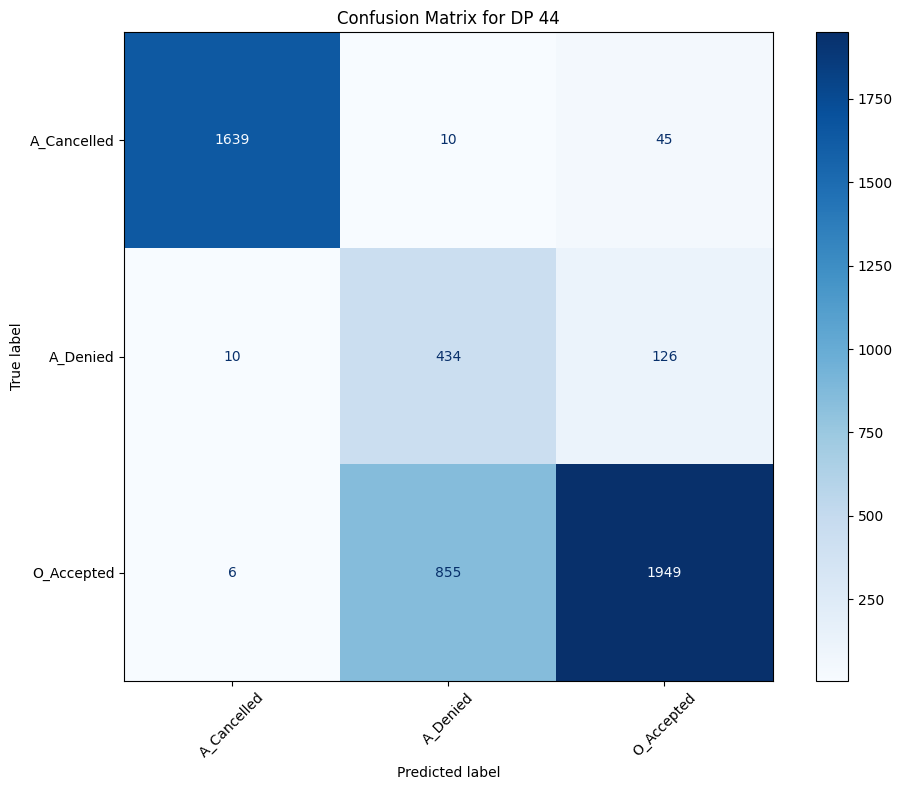

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 46 (Holdout Set)
Weighted F1 (LSTM):     0.821
Weighted F1 (Baseline): 0.448
Relative Improvement:   83.25%


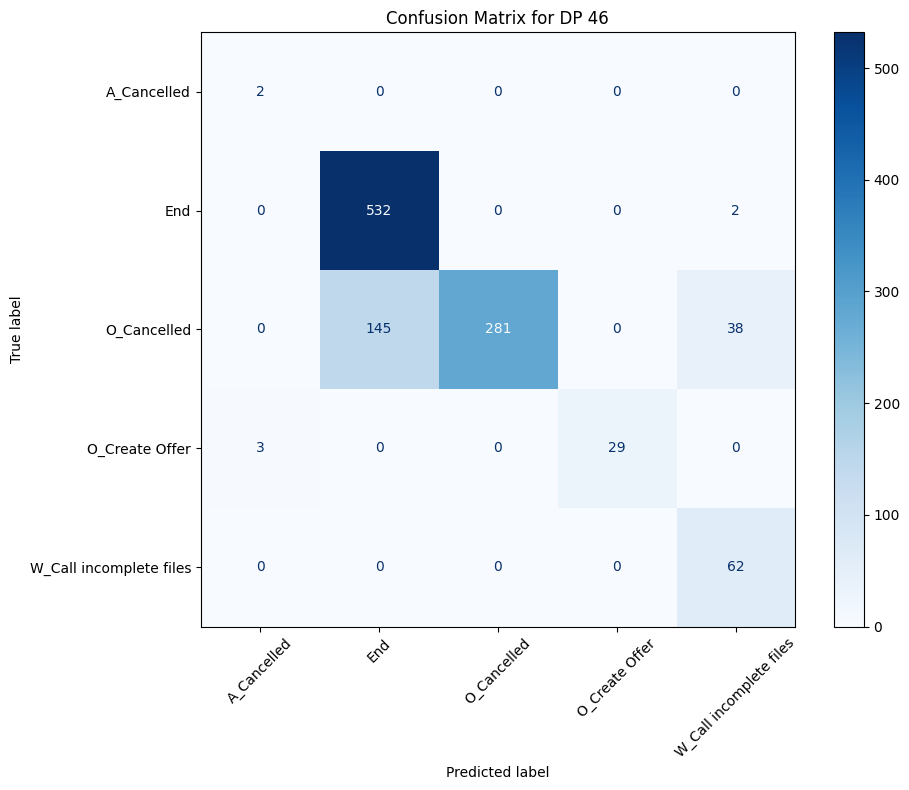

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 47 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.465
Relative Improvement:   114.76%


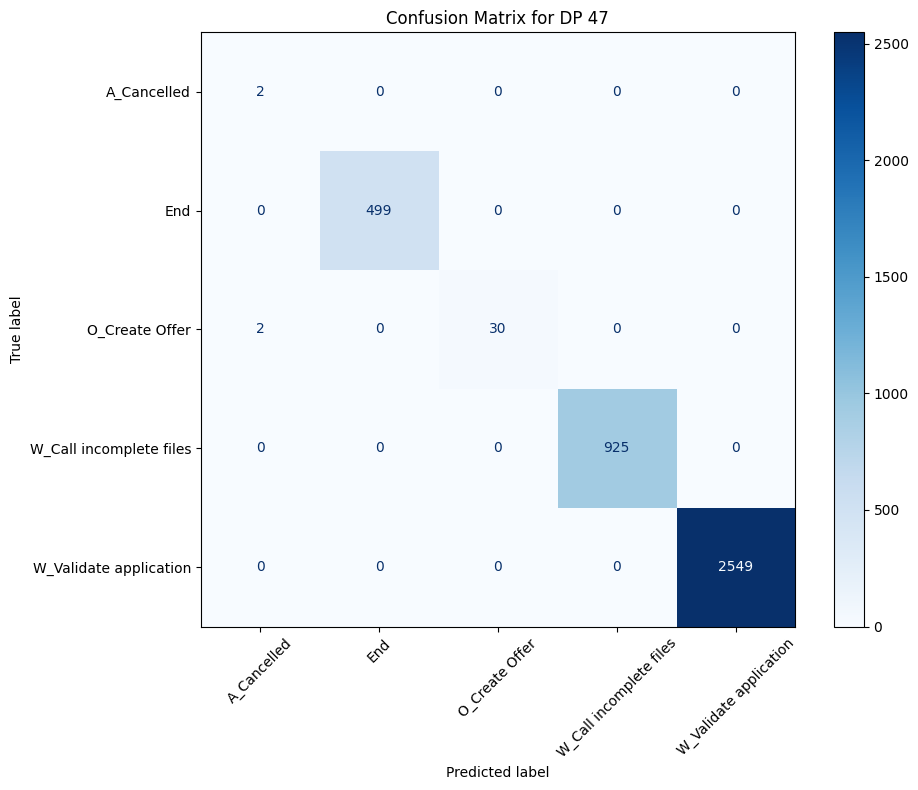

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 48 (Holdout Set)
Weighted F1 (LSTM):     0.768
Weighted F1 (Baseline): 0.329
Relative Improvement:   133.58%


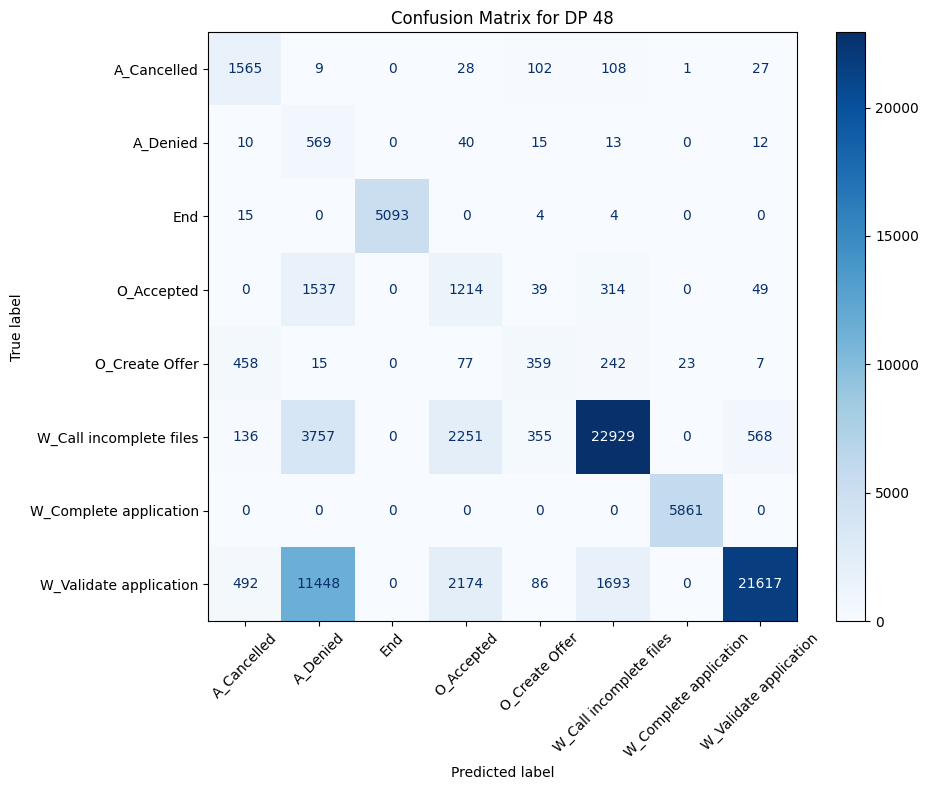

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Comparison for DP 49 (Holdout Set)
Weighted F1 (LSTM):     0.785
Weighted F1 (Baseline): 0.329
Relative Improvement:   138.75%


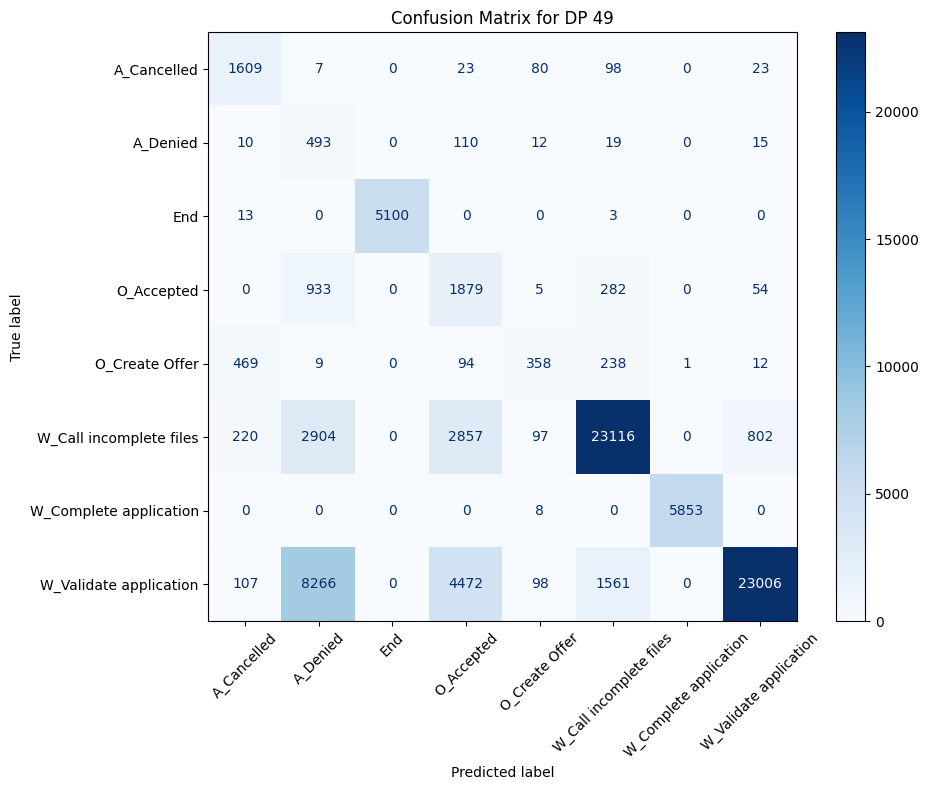

In [6]:
# Step: Build holdout data dict from dp_split_datasets
test_data_per_dp = {
    dp_name: splits["test"]
    for dp_name, splits in dp_split_datasets_full_advanced.items()
    if "test" in splits and not splits["test"].empty
}

# Step: Run evaluation using your existing function
for dp in test_data_per_dp.keys():
    compare_f1_for_trained_model(dp, test_data_per_dp, decision_point_models_advanced)

## 1.4 Hyperparameter-Tuning for Low-Performing Models

In [7]:
# Compute weighted F1-score per decision point without including the grouping column
dp_weighted_f1 = (
    df_accuracy
    .groupby("decision_point")
    .apply(lambda g: (g["f1_score"] * g["support"]).sum() / g["support"].sum(), include_groups=False)
    .reset_index(name="weighted_f1")
)

# Filter decision points below 80%
underperforming_dps = dp_weighted_f1[dp_weighted_f1["weighted_f1"] < 85]
low_accuracy_dps = underperforming_dps["decision_point"].tolist()

print("Decision Points with Weighted F1-score < 85%:\n")
print(underperforming_dps)
print(len(underperforming_dps))

Decision Points with Weighted F1-score < 85%:

   decision_point  weighted_f1
1           DP 10    77.166179
2           DP 11    78.846774
3           DP 12    77.904869
9           DP 19    73.073500
10          DP 20    69.984858
11          DP 21    68.800052
12          DP 22    70.163078
14          DP 25    81.372596
16          DP 27    78.556479
17          DP 28    78.187965
18          DP 29    77.507849
20          DP 30    76.687375
21          DP 31    58.605639
22          DP 32    77.626743
24          DP 34    77.503898
25          DP 35    76.611924
26          DP 36    76.302664
27          DP 37    77.082939
28          DP 39    57.302465
30          DP 40    63.190317
31          DP 41    61.822423
32          DP 42    77.004742
33          DP 43    77.416417
34          DP 44    80.731232
35          DP 46    83.426435
37          DP 48    76.700435
38          DP 49    78.472661
40           DP 7    68.416248
41           DP 8    73.484468
42           DP 9    77

In [8]:
# Store tuned models and their performance
tuned_models = {}

for dp in low_accuracy_dps:
    print(f"\nTuning Decision Point: {dp}")
    
    splits = dp_split_datasets_full_advanced.get(dp)
    if not splits:
        print(f"No data available for {dp}")
        continue

    # Combine train and test data for preprocessing
    df_train = splits["train"]
    df_test = splits["test"]
    df_combined = pd.concat([df_train, df_test], ignore_index=True)

    try:
        # Perform hyperparameter tuning
        best_hp, best_model, label_enc = tune_hyperparameters_for_dp(
            dp_name=dp,
            df=df_combined,
            context_keys=context_keys_advanced,
            max_trials=5,  # Adjust as needed
            executions_per_trial=1,
            target_val_acc=0.9
        )

        # Save the best model and encoder
        tuned_models[dp] = {
            "model": best_model,
            "hyperparameters": best_hp,
            "label_encoder": label_enc
        }

    except Exception as e:
        print(f"Error while tuning {dp}: {e}")

Trial 5 Complete [00h 02m 37s]
val_accuracy: 0.8737452030181885

Best val_accuracy So Far: 0.8817077875137329
Total elapsed time: 00h 12m 45s


/Users/marcohmayer/.pyenv/versions/3.11.8/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# Step 1: Compute weighted F1-scores per decision point
dp_weighted_f1 = (
    df_accuracy
    .groupby("decision_point")
    .apply(lambda g: (g["f1_score"] * g["support"]).sum() / g["support"].sum(), include_groups=False)
    .reset_index(name="weighted_f1")
)

# Convert to dict for fast lookup
dp_f1_dict = dp_weighted_f1.set_index("decision_point")["weighted_f1"].to_dict()

# Step 2: Loop over all DPs and build rows
dp_rows = []
all_decision_points = list(bpmn_decision_point_map.keys())

for dp_name in all_decision_points:
    # Tuned model
    if dp_name in tuned_models:
        model = tuned_models[dp_name]["model"]
        hp = tuned_models[dp_name]["hyperparameters"]
        acc = tuned_models[dp_name].get("final_training_accuracy", None)

        row = {
            "decision_point": dp_name,
            "embedding_dim": hp.get("embedding_dim"),
            "lstm_units": hp.get("lstm_units"),
            "dropout_rate": hp.get("dropout_rate"),
            "learning_rate": round(hp.get("learning_rate"), 6),
        }

    # Non-tuned model → use defaults and fallback to F1
    else:
        fallback_acc = dp_f1_dict.get(dp_name, None)
        row = {
            "decision_point": dp_name,
            "embedding_dim": 64,
            "lstm_units": 128,
            "dropout_rate": 0.3,
            "learning_rate": 0.001,
        }

    dp_rows.append(row)

# Step 3: Create summary DataFrame
df_hyperparams_summary = pd.DataFrame(dp_rows)
df_hyperparams_summary.set_index("decision_point", inplace=True)
df_hyperparams_summary = df_hyperparams_summary.sort_index()
display(df_hyperparams_summary)

,embedding_dim,lstm_units,dropout_rate,learning_rate
decision_point,,,,
DP 1,64,128,0.3,0.001000
DP 10,64,128,0.2,0.001294
DP 11,128,256,0.4,0.001326
DP 12,32,64,0.4,0.003402
DP 13,64,128,0.3,0.001000
DP 14,64,128,0.3,0.001000
DP 15,64,128,0.3,0.001000
DP 16,64,128,0.3,0.001000
DP 17,64,128,0.3,0.001000


In [10]:
# --- Storage ---
final_holdout_predictions_advanced = {}
accuracy_per_class = []
models_advanced_holdout = {}


# Loop over each decision point
for dp_name in df_hyperparams_summary.index:
    print(f"\nRetraining and predicting holdout for: {dp_name}")

    try:
        # Get data splits
        splits = dp_split_datasets_full_advanced.get(dp_name)
        if not splits or "holdout" not in splits:
            print(f"No holdout set for {dp_name}")
            continue

        # Combine training + test for training
        df_train = pd.concat([splits["train"], splits["test"]], ignore_index=True)
        df_holdout = splits["holdout"]

        # Prepare sequences
        X_acts, X_durs, X_res, act_enc, res_enc, label_encoder, y_train_all, max_seq_len = prepare_sequences_and_labels(df_train)
        X_acts_hold, X_durs_hold, X_res_hold, _, _, _, y_holdout, _ = prepare_sequences_and_labels(df_holdout)

        # Context attributes
        X_ctx_train, context_dim, _ = prepare_context_attributes(df_train, context_keys_advanced)
        X_ctx_hold, _, _ = prepare_context_attributes(df_holdout, context_keys_advanced)

        # --- Model params from summary ---
        params = df_hyperparams_summary.loc[dp_name]
        embedding_dim = int(params["embedding_dim"])
        lstm_units = int(params["lstm_units"])
        dropout_rate = params["dropout_rate"]
        learning_rate = params["learning_rate"]
        num_classes = len(label_encoder.classes_)

        # Build model
        model = build_lstm_model_advanced(
            num_activities=len(act_enc.classes_),
            num_resources=len(res_enc.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=num_classes,
            embedding_dim=embedding_dim,
            lstm_units=lstm_units,
            dropout_rate=dropout_rate
        )

        # Compile with specific learning rate
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        # Train
        model.fit(
            x=[X_acts, X_durs, X_res, X_ctx_train],
            y=y_train_all,
            batch_size=64,
            epochs=10,
            verbose=1  # set to 1 if you want to see training progress
        )

        # Predict on holdout
        y_pred_probs = model.predict([X_acts_hold, X_durs_hold, X_res_hold, X_ctx_hold])
        y_pred = np.argmax(y_pred_probs, axis=1)

        lstm_report = classification_report(y_holdout, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
        baseline_report = evaluate_baseline(y_holdout, label_encoder)  # If using dist baseline now

        print(f"\n--- [ADVANCED LSTM] Results for {dp_name} ---")
        for label in label_encoder.classes_:
            if label in lstm_report:
                print(f"{label}: Precision={lstm_report[label]['precision']:.2f}, Recall={lstm_report[label]['recall']:.2f}, F1={lstm_report[label]['f1-score']:.2f}")

        # --- Store per-class results ---
        for label in label_encoder.classes_:
            if label in lstm_report:
                accuracy_per_class.append({
                    "decision_point": dp_name,
                    "label": label,
                    "precision": round(lstm_report[label]["precision"] * 100, 2),
                    "recall": round(lstm_report[label]["recall"] * 100, 2),
                    "f1_score": round(lstm_report[label]["f1-score"] * 100, 2),
                    "support": lstm_report[label]["support"]
                })
            if label in baseline_report:
                baseline_accuracy_per_class.append({
                    "decision_point": dp_name,
                    "label": label,
                    "precision": round(baseline_report[label]["precision"] * 100, 2),
                    "recall": round(baseline_report[label]["recall"] * 100, 2),
                    "f1_score": round(baseline_report[label]["f1-score"] * 100, 2),
                    "support": baseline_report[label]["support"]
                })

        # Store model and metadata
        models_advanced_holdout[dp_name] = {
            "model": model,
            "activity_encoder": act_enc,
            "resource_encoder": res_enc,
            "label_encoder": label_encoder,
            "context_keys": context_keys_advanced,
            "max_seq_len": max_seq_len
        }

    except Exception as e:
        print(f"Error with {dp_name}: {e}")


Retraining and predicting holdout for: DP 1
Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8609 - loss: 0.3642
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9976 - loss: 0.0075
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9996 - loss: 0.0018
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 7.1279e-04
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 6.9774e-04
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 6.7453e-04
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.9696e-04
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.1927e-04
Epoch 9/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 4.8181e-05
Epoch 10/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0019
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- [ADVANCED LSTM] Results fo

In [12]:
# Convert results to DataFrames
df_accuracy = pd.DataFrame(accuracy_per_class)

# Calculate total support per decision point (for per-DP percentage if needed)
total_support_per_dp = df_accuracy.groupby("decision_point")["support"].transform("sum")
df_accuracy["support_percentage"] = round(df_accuracy["support"] / total_support_per_dp * 100, 2)

# --- Overall Weighted Metrics ---
weighted_precision_lstm = (df_accuracy["precision"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_recall_lstm = (df_accuracy["recall"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_f1_lstm = (df_accuracy["f1_score"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()

weighted_precision_majority = (df_baseline["precision"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_recall_majority = (df_baseline["recall"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_f1_majority = (df_baseline["f1_score"] * df_baseline["support"]).sum() / df_baseline["support"].sum()

# Relative improvements
relative_improvement_f1 = (weighted_f1_lstm - weighted_f1_majority) / weighted_f1_majority * 100
relative_improvement_precision = (weighted_precision_lstm - weighted_precision_majority) / weighted_precision_majority * 100
relative_improvement_recall = (weighted_recall_lstm - weighted_recall_majority) / weighted_recall_majority * 100

# --- Print Global Comparison ---
print("\n=== Global Comparison Across All Decision Points ===")
print(f"Weighted Precision (LSTM):     {weighted_precision_lstm:.3f}")
print(f"Weighted Precision (Majority): {weighted_precision_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_precision:.2f}%\n")

print(f"Weighted Recall (LSTM):        {weighted_recall_lstm:.3f}")
print(f"Weighted Recall (Majority):    {weighted_recall_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_recall:.2f}%\n")

print(f"Weighted F1 (LSTM):            {weighted_f1_lstm:.3f}")
print(f"Weighted F1 (Majority):        {weighted_f1_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_f1:.2f}%")


=== Global Comparison Across All Decision Points ===
Weighted Precision (LSTM):     86.999
Weighted Precision (Majority): 40.554
Relative Improvement:          114.52%

Weighted Recall (LSTM):        88.893
Weighted Recall (Majority):    40.574
Relative Improvement:          119.09%

Weighted F1 (LSTM):            86.921
Weighted F1 (Majority):        40.562
Relative Improvement:          114.29%


## 1.5 Comparison of Majority Predictor & LSTM per Decision Point on Test-Set (After Tuning)

## 1.6 Final Prediction on Hold-Out-Set

## 1.7 Final Permutation Importance

## 1.8 Final Training & Storage

In [ ]:
# --- Storage ---
final_models_trained_on_full_data = {}

# Loop over all decision points
for dp_name in df_hyperparams_summary.index:
    print(f"\nRetraining on FULL dataset for: {dp_name}")

    try:
        # Get all data splits
        splits = dp_split_datasets_full_advanced.get(dp_name)
        if not splits:
            print(f"No data available for {dp_name}")
            continue

        # Combine all data: train + test + holdout
        df_full = pd.concat([splits["train"], splits["test"], splits["holdout"]], ignore_index=True)

        # Prepare inputs
        X_acts, X_durs, X_res, act_enc, res_enc, label_enc, y_full, max_seq_len = prepare_sequences_and_labels(df_full)
        X_ctx, context_dim, context_encoders = prepare_context_attributes(df_full, context_keys_advanced)

        # 🔧 Add "UNKNOWN" to all label encoders (if not already present)
        def ensure_unknown(encoder):
            if "UNKNOWN" not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, "UNKNOWN")

        ensure_unknown(act_enc)
        ensure_unknown(res_enc)
        ensure_unknown(label_enc)
        for enc in context_encoders.values():
            if isinstance(enc, LabelEncoder):
                ensure_unknown(enc)

        # Get hyperparameters
        params = df_hyperparams_summary.loc[dp_name]
        embedding_dim = int(params["embedding_dim"])
        lstm_units = int(params["lstm_units"])
        dropout_rate = float(params["dropout_rate"])
        learning_rate = float(params["learning_rate"])
        num_classes = len(label_enc.classes_)

        # Build model
        model = build_lstm_model_advanced(
            num_activities=len(act_enc.classes_),
            num_resources=len(res_enc.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=num_classes,
            embedding_dim=embedding_dim,
            lstm_units=lstm_units,
            dropout_rate=dropout_rate
        )

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        train_model_advanced(model, [X_acts, X_durs, X_res, X_ctx], y_full)

        # Store model and encoders
        final_models_trained_on_full_data[dp_name] = {
            "model": model,
            "label_encoder": label_enc,
            "activity_encoder": act_enc,
            "resource_encoder": res_enc,
            "context_dim": context_dim,
            "context_encoders": context_encoders,
            "context_keys": context_keys_advanced,
            "max_seq_len": max_seq_len
        }

        print(f"Successfully trained final model for {dp_name}")

    except Exception as e:
        print(f"Error while retraining {dp_name}: {e}")

In [ ]:
# Go up from notebooks/ to project root, then into models/models_advanced
save_dir = os.path.join("..", "models", "models_advanced")
os.makedirs(save_dir, exist_ok=True)

for dp_name, data in final_models_trained_on_full_data.items():
    dp_path = os.path.join(save_dir, dp_name)
    os.makedirs(dp_path, exist_ok=True)

    # Save model
    model_path = os.path.join(dp_path, "model.keras")
    data["model"].save(model_path)

    # Save encoders
    joblib.dump(data["activity_encoder"], os.path.join(dp_path, "activity_encoder.pkl"))
    joblib.dump(data["resource_encoder"], os.path.join(dp_path, "resource_encoder.pkl"))
    joblib.dump(data["label_encoder"], os.path.join(dp_path, "label_encoder.pkl"))
    joblib.dump(data["context_encoders"], os.path.join(dp_path, "context_encoders.pkl"))

    # Save metadata
    metadata = {
        "context_keys": data["context_keys"],
        "max_seq_len": data["max_seq_len"]
    }
    joblib.dump(metadata, os.path.join(dp_path, "metadata.pkl"))

print(f"Saved models to {os.path.abspath(save_dir)}")